In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import tweepy
import csv
import urllib.request
import warnings
from textblob import TextBlob
import re
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore")

# Web Scraping using Beautiful Soup

In [2]:
#The first thing we'll need to do to scrape a web page is to download the page. 
#The requests library will make a GET request to a web server, which will download the HTML contents of a given web page.

page = requests.get("https://twittercounter.com/pages/100/india")

In [3]:
page

<Response [200]>

In [4]:
#After running our request, we get a Response object. 
#This object has a status_code property, which indicates if the page was downloaded successfully:
page.status_code

200

In [416]:
type(page.content)


bytes

In [7]:
soup = BeautifulSoup(page.content, 'html.parser')

In [417]:
#Makes the data  well structured with all tags nested and indented properly
print(soup.prettify())

In [418]:
#As all the tags are nested, we can move through the structure one level at a time. 
#We can first select all the elements at the top level of the page using the children property of soup. 
#Note that children returns a list generator, so we need to call the list function on it:
list(soup.children)

In [10]:
[type(item) for item in list(soup.children)]

[bs4.element.Doctype,
 bs4.element.NavigableString,
 bs4.element.Tag,
 bs4.element.NavigableString]

In [11]:
#As you can see, all of the items are BeautifulSoup objects. 
#The first is a Doctype object, which contains information about the type of the document. 
#The second is a NavigableString, which represents text found in the HTML document. 
#The final item is a Tag object, which contains other nested tags. 

#The Tag object allows us to navigate through an HTML document, and extract other tags and text. 

html = list(soup.children)[2]

In [419]:
#Each item in the list returned by the children property is also a BeautifulSoup object, 
#so we can also call the children method on html.
list(html.children)

In [420]:
#There are two tags here, head, and body. We want to explore body
body = list(html.children)[3]
body

In [421]:
list(body.children)

In [422]:
#Finding all instances of a tag at once
soup.find_all('a')

In [423]:
soup.find_all('a', class_='uname')

In [30]:
soup.find_all('a', class_='uname')[0].get_text()

'@narendramodi'

In [404]:
popularTweeters = list(soup.find_all('a', class_='uname'))
tweeterNames = [i.get_text() for i in popularTweeters]
tweeterNames[:10]

['@narendramodi',
 '@SrBachchan',
 '@iamsrk',
 '@BeingSalmanKhan',
 '@PMOIndia',
 '@akshaykumar',
 '@sachin_rt',
 '@aamir_khan',
 '@deepikapadukone',
 '@imVkohli']

In [73]:
#Twitter API credentials
consumer_key = "LvltFzjUcqdVtrmeWj4sgRHOW"
consumer_secret = "T8upM51nk3AJcK2qLbgervy9LfRmWu5PZ2xguSDi89t5wNnqVP"
access_key = "57291689-yUN8dYEB3hWAenxhcMYWiDImp3m97zKNcXVC8uiqi"
access_secret = "LmqpZlC7Lo8TkAqAQNYzQGp82Rz2YYdYoVvd0D0q2KJNq"

In [134]:
def get_profile_picture(screenName):

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    userobj = api.get_user(screen_name = screenName)
    urllib.request.urlretrieve(userobj.profile_image_url_https, '%s_profile_pic.jpeg' % screenName) # save image to disk

In [359]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    #initialize a list to hold all the tweepy Tweets
    alltweets = []	

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=100)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #transform the tweepy tweets into a 2D array that will populate the csv	
    outtweets = [[tweet.text.encode("utf-8"), tweet.source] for tweet in alltweets]
    
    #write the csv	
    with open('%s_tweets.csv' % screen_name, 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["text", "source"])
        writer.writerows(outtweets)
        

In [360]:
def getTweets(tweeple):
    for i in tweeple:
        get_all_tweets(i)

In [361]:
getTweets(tweeterNames)

In [132]:
def getProfilePictures(tweeple):
     for i in tweeple:
        get_profile_picture(i)

In [135]:
getProfilePictures(tweeterNames)

In [162]:
def concat_tweets(screen_name):
    twitterName = screen_name + '_tweets.csv'
    myfile = pd.read_csv(twitterName)
    
    concatString = ""

    for i in myfile['text']:
        concatString +=i
        
    return concatString
    

In [163]:
def concatTweets(tweeple):
    
    combinedTweets = []
    
    for i in tweeple:
        combinedTweets.append(concat_tweets(i))
        
    return combinedTweets
        
    

In [165]:
user_language_array = concatTweets(tweeterNames)

In [166]:
len(user_language_array)

100

In [167]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, stop_words = 'english',\
                             strip_accents = 'unicode', lowercase=True, ngram_range=(1,2),\
                            norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

X = vectorizer.fit_transform(user_language_array)
D = -(X * X.T).todense() # Distance matrix: dot product between tfidf vectors

# Sentiment Analysis of tweets using TextBlob 


In [3]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


In [222]:
def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [223]:
twitterName = '@narendramodi' + '_tweets.csv'
myfile = pd.read_csv(twitterName)

In [237]:
myfile['SA'] = np.array([ analyze_sentiment(tweet) for tweet in myfile['text'] ])

In [238]:
myfile[0:4]

,text,SA
0,"b""Congratulations @vishy64theking! You've prov...",0
1,b'Warm birthday greetings to my valued colleag...,1
2,"b'In Shimla, relished coffee at the Indian Cof...",1
3,b'I thank the people of Shimla for the warm we...,1


In [243]:
pos_tweets = myfile[myfile['SA'] > 0].count()
neu_tweets = myfile[myfile['SA'] == 0].count()
neg_tweets = myfile[myfile['SA'] < 0].count()

In [250]:
print("Percentage of positive tweets: {}%".format(pos_tweets.text*100/len(myfile['text'])))
print("Percentage of neutral tweets: {}%".format(neu_tweets.text*100/len(myfile['text'])))
print("Percentage of negative tweets: {}%".format(neg_tweets.text*100/len(myfile['text'])))

Percentage of positive tweets: 42.0%
Percentage of neutral tweets: 52.0%
Percentage of negative tweets: 6.0%


In [247]:
pos_tweets.text

42

In [251]:
def processTweets(screen_name):
    twitterName = screen_name + '_tweets.csv'
    myfile = pd.read_csv(twitterName)
    
    #Create new column for sentiment analysis:
    myfile['SA'] = np.array([ analyze_sentiment(tweet) for tweet in myfile['text'] ])
    
    return myfile
    

In [263]:
twitterDf = pd.DataFrame()


In [265]:
twitterDf['Top 100 Users'] = tweeterNames

In [403]:
def fillDataframe(users):
    posTweets = []
    neuTweets = []
    negTweets = []

    for i in users:
        twitterName = i + '_tweets.csv'
        myfile = pd.read_csv(twitterName)

        myfile['SA'] = np.array([analyze_sentiment(tweet) for tweet in myfile['text']])

        pos_tweets = myfile[myfile['SA'] > 0].count()
        neu_tweets = myfile[myfile['SA'] == 0].count()
        neg_tweets = myfile[myfile['SA'] < 0].count()

        posTweets.append(pos_tweets.text)
        neuTweets.append(neu_tweets.text)
        negTweets.append(neg_tweets.text)

    twitterDf['Positive Tweets'] = posTweets
    twitterDf['Neutral Tweets'] = neuTweets
    twitterDf['Negative Tweets'] = negTweets
    
    return myfile

In [317]:
fillDataframe(tweeterNames)

,text,SA
0,b'@siakhanofficial You\xe2\x80\x99ve chosen on...,0
1,b'It\xe2\x80\x99s humbling to perform in small...,1
2,b'@ArtofLiving @voicesofiwc @mangeshkarlata \x...,0
3,b'Just arrived in Mumbai by an early morning f...,1
4,b'Thank you Hyderabad for being such a great a...,1
5,b'Caught him at Mumbai airport \xf0\x9f\x98\x8...,0
6,b'Very pleased that Asha\xe2\x80\x99s Birmingh...,1
7,b'From the recently concluded Dubai Concert ht...,0
8,b'Enjoying the company of my age group \xf0\x9...,1
9,b'Thank you Dubai \xf0\x9f\x99\x8f\xf0\x9f\x8f...,0


In [318]:
twitterDf.head(10)

,Top 100 Users,Positive Tweets,Neutral Tweets,Negative Tweets
0,@narendramodi,42,52,6
1,@SrBachchan,50,46,3
2,@iamsrk,55,41,4
3,@BeingSalmanKhan,33,63,4
4,@PMOIndia,26,67,7


In [277]:
#twitterDf.to_csv('twitterSentiment.csv', sep=',')

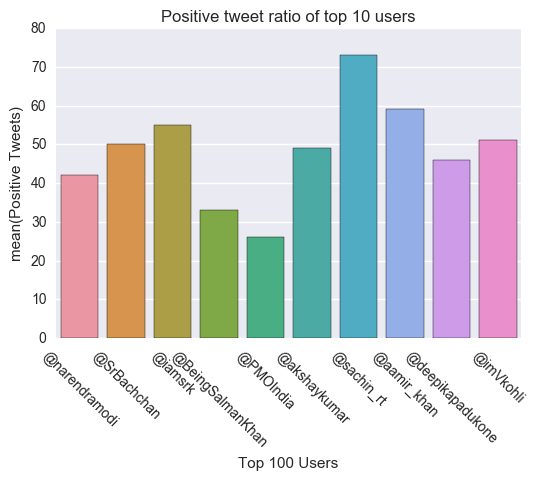

In [406]:
sns.barplot(x="Top 100 Users", y="Positive Tweets", data=twitterDf[:10]);
# Rotate x-labels
plt.xticks(rotation=-45)
plt.title("Positive tweet ratio of top 10 users")

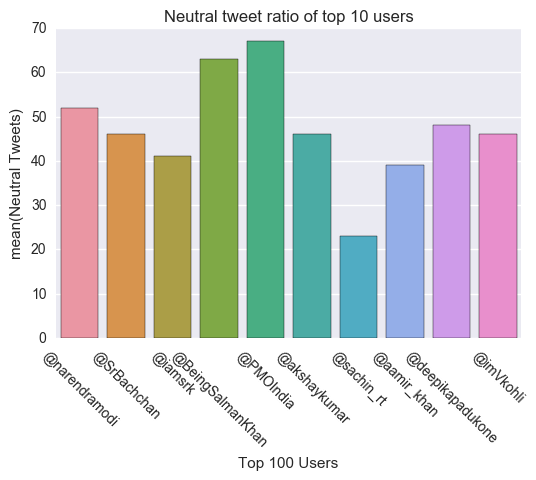

In [303]:
sns.barplot(x="Top 100 Users", y="Neutral Tweets", data=twitterDf[:10]);
# Rotate x-labels
plt.xticks(rotation=-45)
plt.title("Neutral tweet ratio of top 10 users")

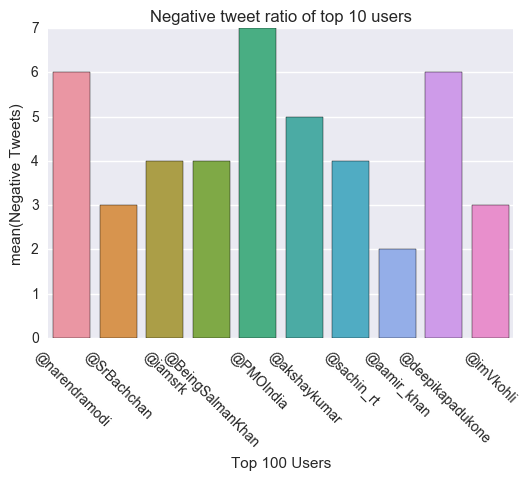

In [304]:
sns.barplot(x="Top 100 Users", y="Negative Tweets", data=twitterDf[:10]);
# Rotate x-labels
plt.xticks(rotation=-45)
plt.title("Negative tweet ratio of top 10 users")

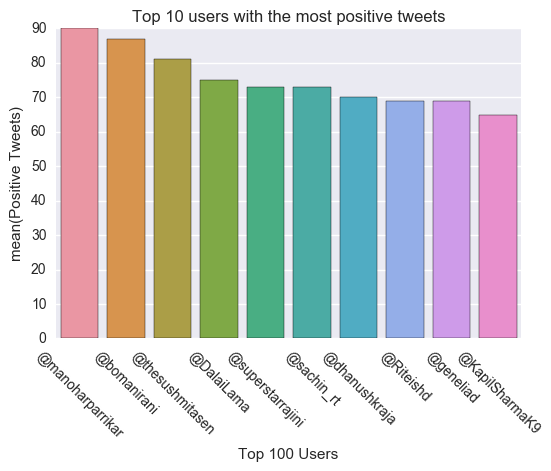

In [305]:
sns.barplot(x="Top 100 Users", y="Positive Tweets", data=twitterDf.sort_values(['Positive Tweets'], ascending = [False])[:10]);
# Rotate x-labels
plt.xticks(rotation=-45)
plt.title("Top 10 users with the most positive tweets")

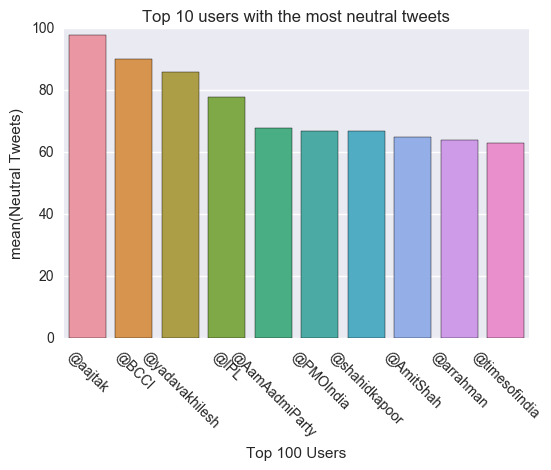

In [306]:
sns.barplot(x="Top 100 Users", y="Neutral Tweets", data=twitterDf.sort_values(['Neutral Tweets'], ascending = [False])[:10]);
# Rotate x-labels
plt.xticks(rotation=-45)
plt.title("Top 10 users with the most neutral tweets")

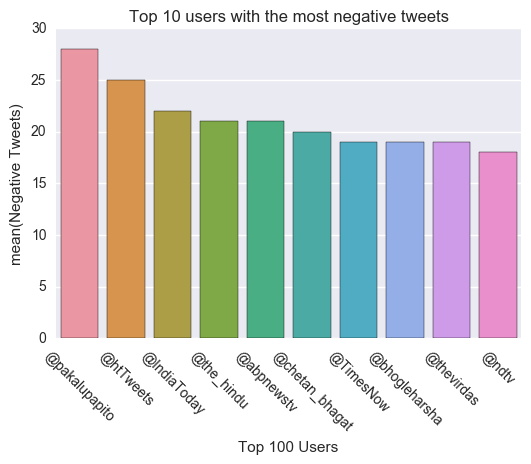

In [310]:
sns.barplot(x="Top 100 Users", y="Negative Tweets", data=twitterDf.sort_values(['Negative Tweets'], ascending = [False])[:10]);
# Rotate x-labels
plt.xticks(rotation=-45)
plt.title("Top 10 users with the most negative tweets")

# Analyzing some of the positive, negative & neutral tweets

In [408]:
twitterName = '@htTweets' + '_tweets.csv'
myfile = pd.read_csv(twitterName)

myfile['SA'] = np.array([analyze_sentiment(tweet) for tweet in myfile['text']])


   

In [411]:
#Negative tweets
myfile[myfile['SA'] == -1]['text']

0     b'Beware, chronic poor sleep may contribute to...
4     b'Why there is a bad smell about life insuranc...
20    b'Delhi: Businessman brutally assaulted by \xe...
21    b'Delhi witnessed 40% rise in deaths due to re...
28    b'Why there is a bad smell about life insuranc...
29    b'Foreign agencies seek CBI help to nab 21 Ind...
45    b'Pakistan man acquitted of blasphemy after 9 ...
49    b'RT @htTweets: #HTPoll| Do you think Pakistan...
53    b'Why there is a bad smell about life insuranc...
56    b'RT @HTSportsNews: Shiv Kapur two behind lead...
66    b'India facing possible mental health epidemic...
68    b'Padmavati: CBFC move fails to mollify Rajput...
72    b'Nirbhaya Fund not being used for women: Moth...
73    b'Crude bomb explosion at two places in Kerala...
74    b'RT @HTSportsNews: I-League: Neroca equalise ...
80    b'Errant CAs may face bigger fines, criminal a...
83    b'Palestine says sorry to India for presence o...
90    b'Not doing what it was expected to do: 8 

In [412]:
#Positive tweets
myfile[myfile['SA'] == 1]['text']

2     b'One of the joyous moments of 2017 was the di...
3     b'The battle against sexual harassment is far ...
6     b'RT @HTSportsNews: .@sachin_rt says current I...
7     b'16-year-old injured during celebratory gunfi...
8     b'Overcrowding a threat to safety in fire-safe...
10    b'Three top firms served notices for not passi...
17    b'Manchester fire: 12 fire engines tackling bl...
19    b'Watch: Video of man confronting Haryana Poli...
31    b'All police stations in Telangana to have soc...
36    b'Google\xe2\x80\x99s high-altitude internet b...
37    b'In 2018, India\xe2\x80\x99s newsmakers vow t...
38    b'The battle against sexual harassment is far ...
39    b'#Column | If you make one promise in the new...
40    b'Govt will take care of right-wingers\xe2\x80...
42    b'RT @HTSportsNews: .@WrestlerSushil faces hea...
46    b'One of the joyous moments of 2017 was the di...
47    b'Videos show Egyptian church gunman confident...
52    b'RT @jeelanikash: Senior @AamAadmiParty l

In [413]:
#Neutral tweets
myfile[myfile['SA'] == 0]['text']

1     b'Manchester fire engulfs 12-storey residentia...
5     b'When life hurts or maims you, seek refuge, a...
9     b'Number of taxis rises 86% in 2 years, buses ...
11    b'RT @HTSportsNews: #INDvSA Indian batsmen hop...
12    b'RT @HTSportsNews: #INDvSA : Series not about...
13    b'Seer\xe2\x80\x99s deadline for Karnataka CM ...
14    b'AAP chooses Sanjay Singh as one of three nom...
15    b'RT @HTSportsNews: Marcelinho\xe2\x80\x99s ha...
16    b'Pakistan lawmaker calls for Doraemon ban to ...
18    b'Gujarat deputy CM Nitin Patel \xe2\x80\x98mi...
22    b'Fire breaks out at 12-storey building in Man...
23    b'RT @HTSportsNews: .@serenawilliams unsure ab...
24    b'Parliament house panel seeks federal body to...
25    b'Viswanathan Anand clinches bronze at World B...
26    b'RT @HTSportsNews: Prajnesh Gunneswaran, Sumi...
27    b'Woof! Dog squad to sniff out smugglers at De...
30    b'Car dealer chases snatchers for 2km on south...
32    b'Army chief reviews security in Jammu and

# Visualizing the sources of tweets

In [364]:
# We obtain all possible sources:
sources = []


for source in data['source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Twitter Web Client
* Media Studio
* Twitter for Android


In [385]:
list(set(data['source']))

['Twitter Web Client',
 'Media Studio',
 'Twitter for iPhone',
 'Twitter for Android']

In [386]:
def identifySources(username):
    twitterName = username + '_tweets.csv'
    data = pd.read_csv(twitterName)
    
    #Identify all unique sources of data
    sources = list(set(data['source']))
    # We create a numpy vector mapped to labels:
    percent = np.zeros(len(sources))
    
    for source in data['source']:
        for index in range(len(sources)):
            if source == sources[index]:
                percent[index] += 1
                pass

    percent /= 100

    # Pie chart:
    pie_chart = pd.Series(percent, index=sources, name='Sources')
    pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6), title = username);

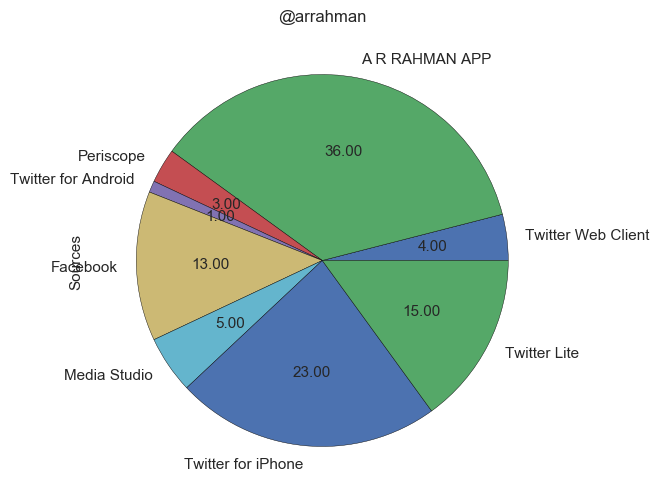

In [401]:
identifySources('@arrahman')

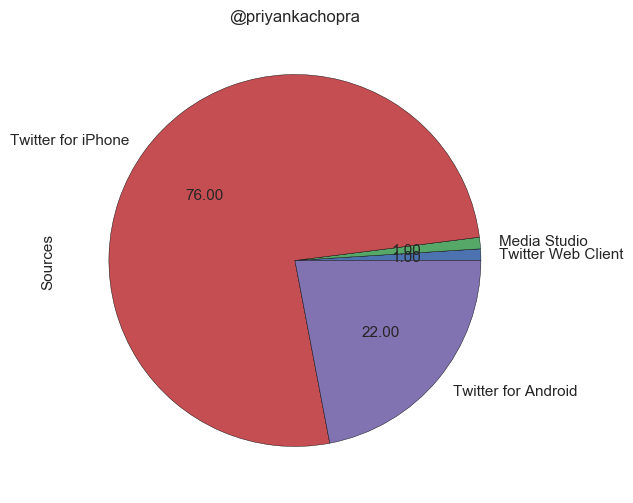

In [400]:
identifySources('@priyankachopra')

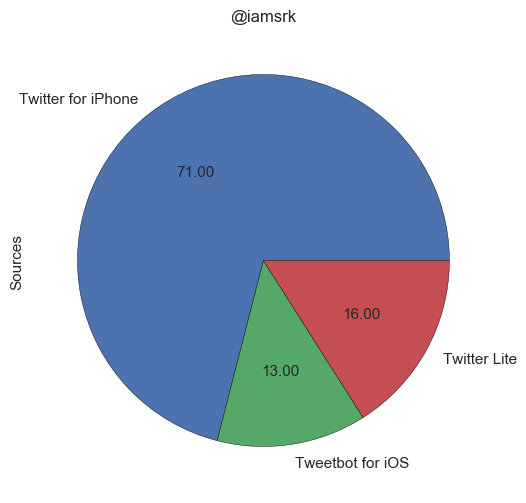

In [415]:
identifySources('@iamsrk')

# Identifying sources of tweets for the top 100 users (Scroll through)

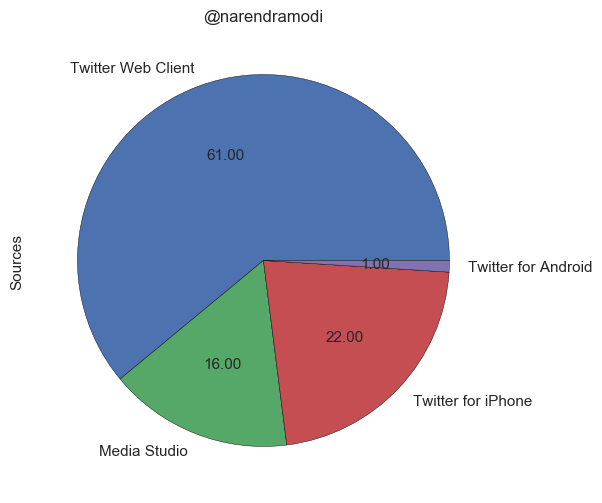

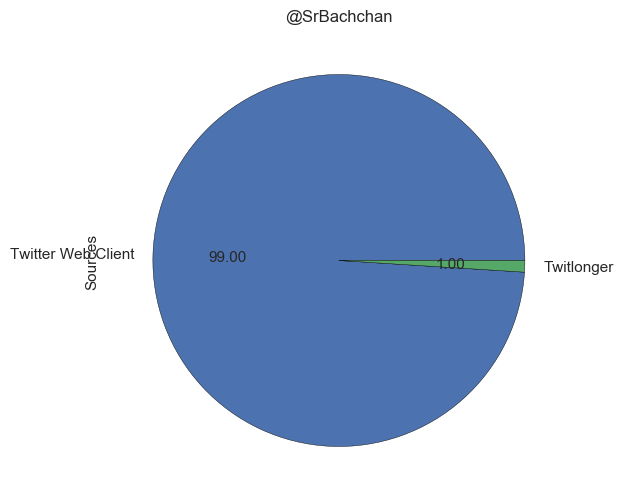

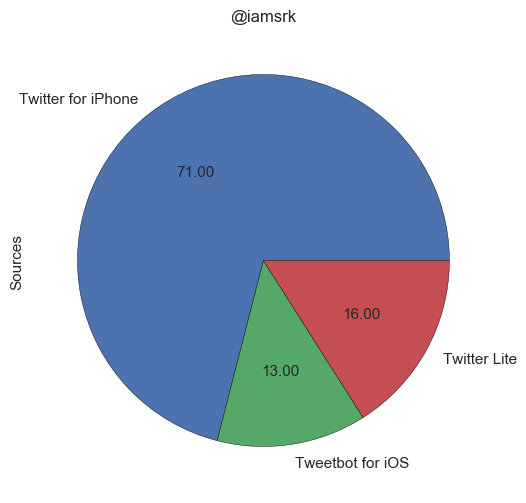

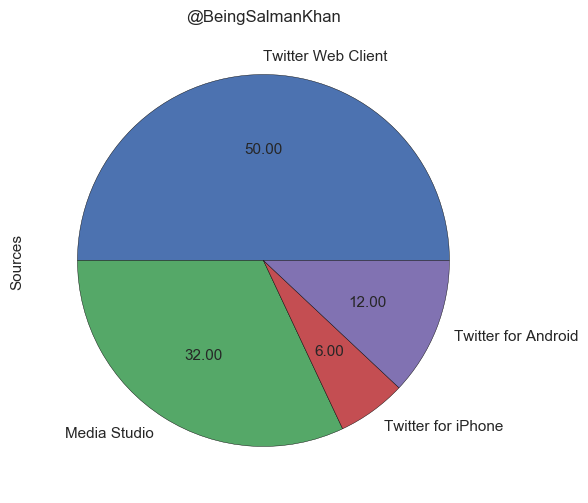

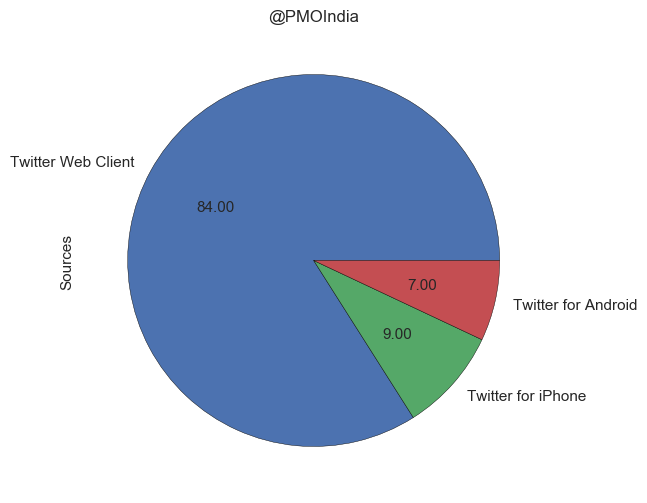

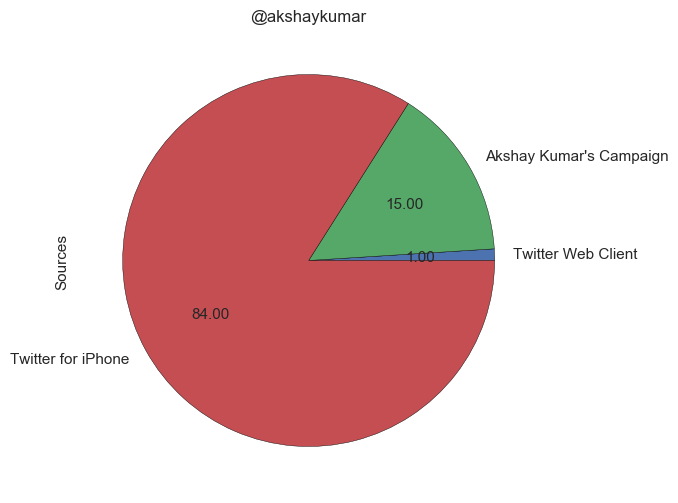

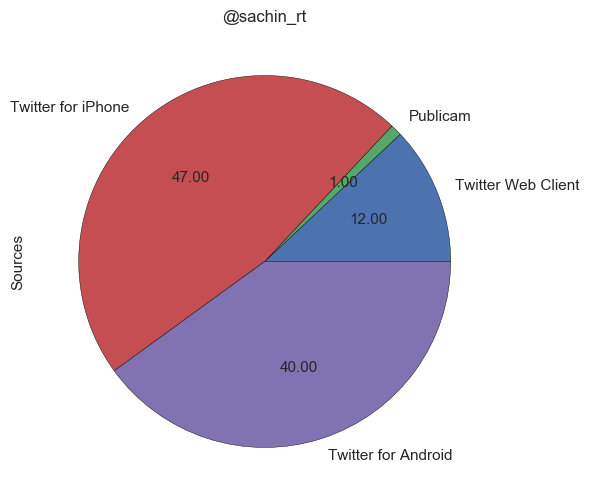

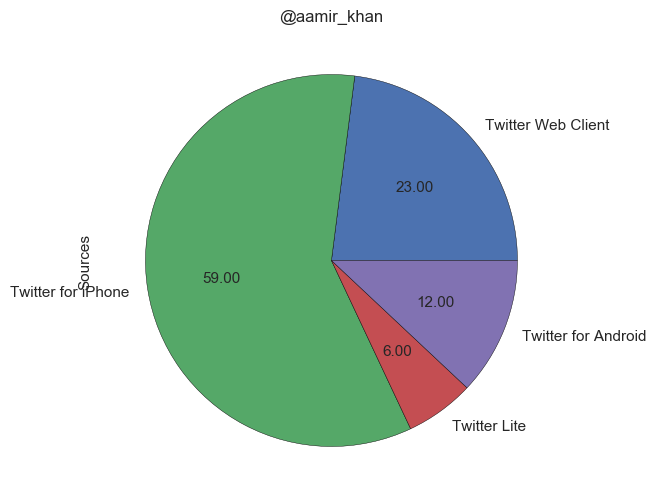

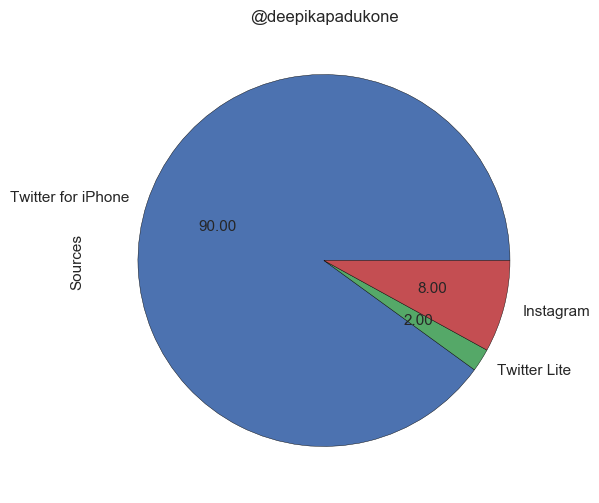

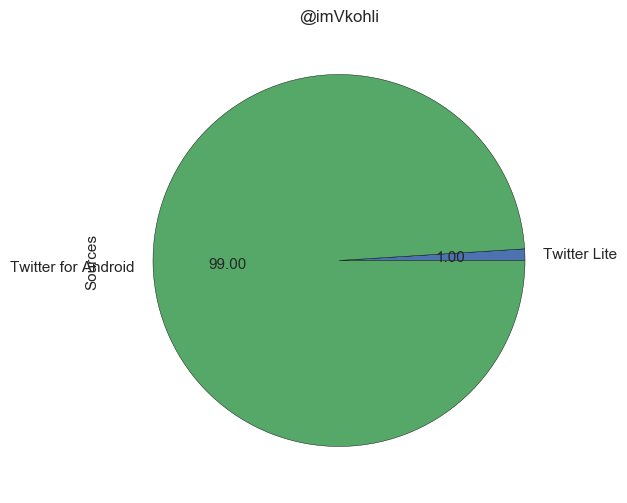

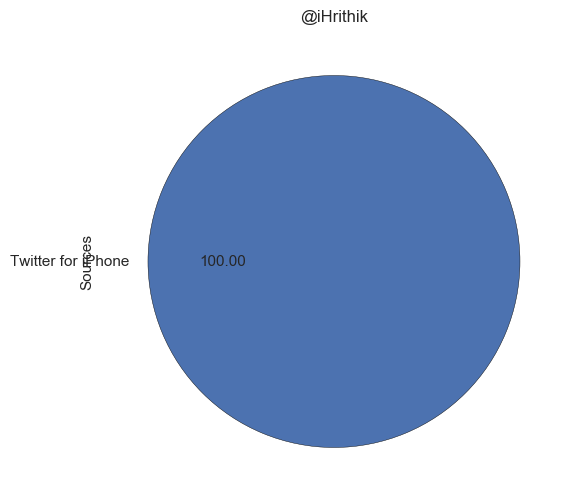

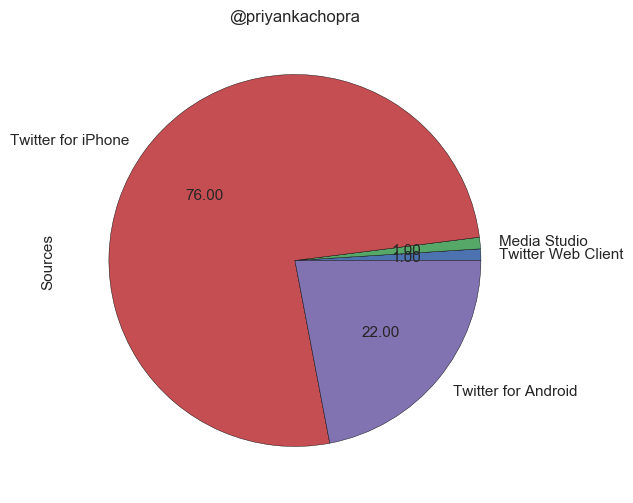

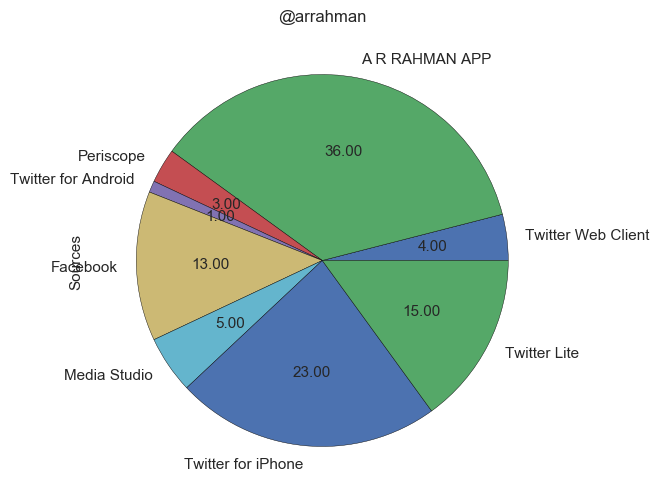

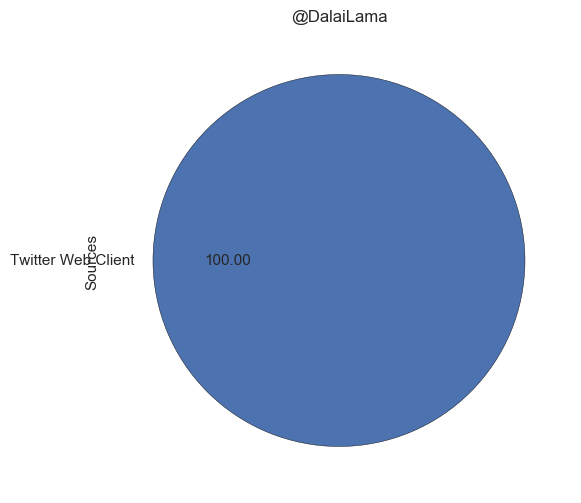

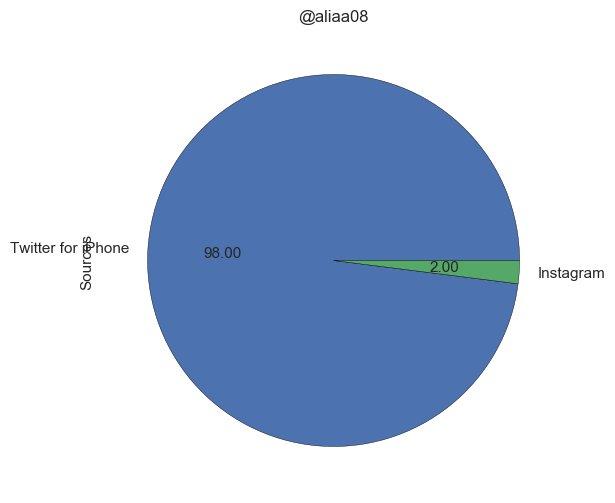

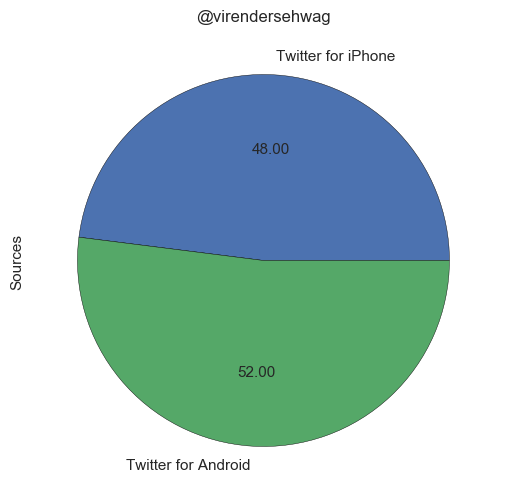

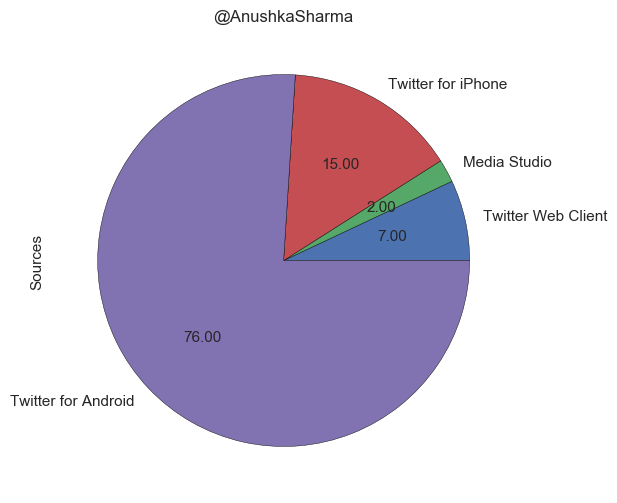

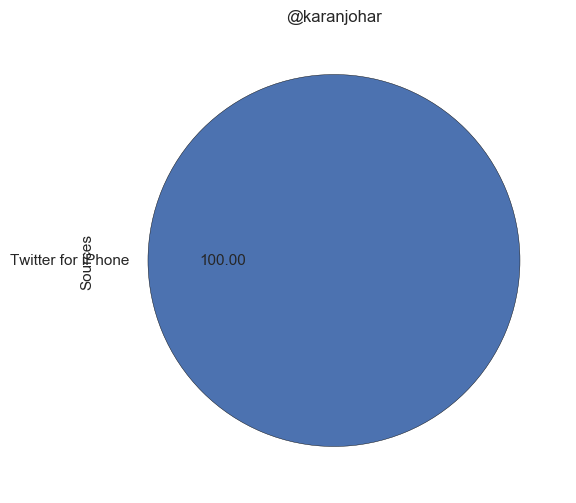

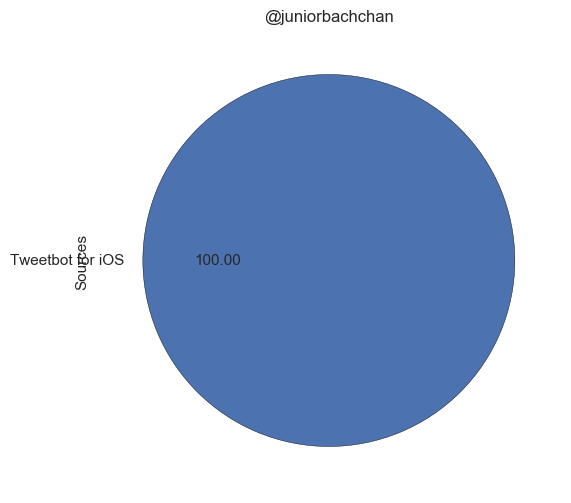

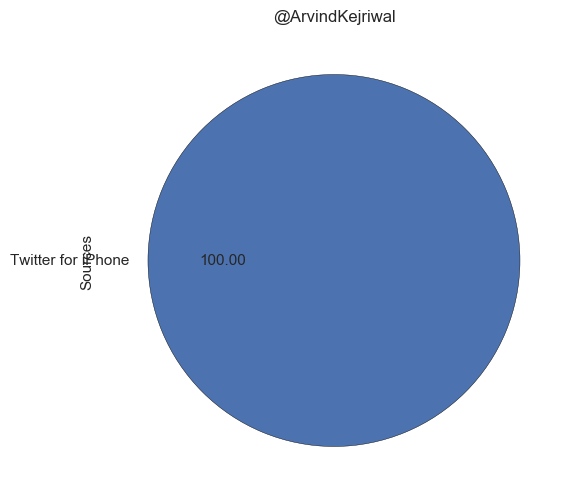

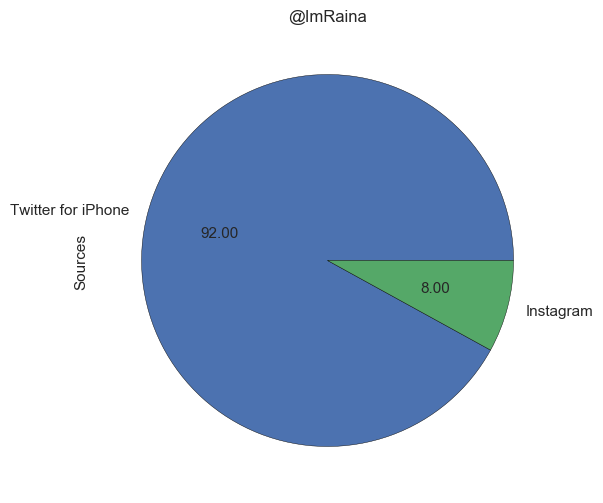

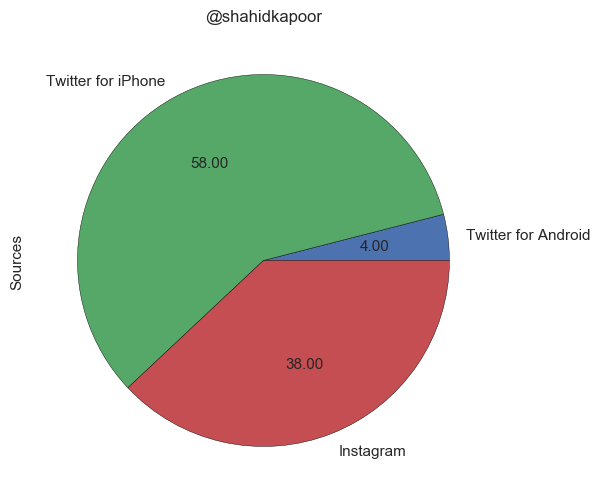

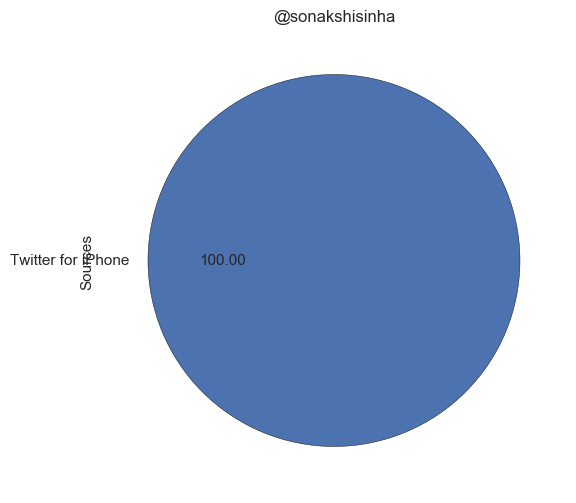

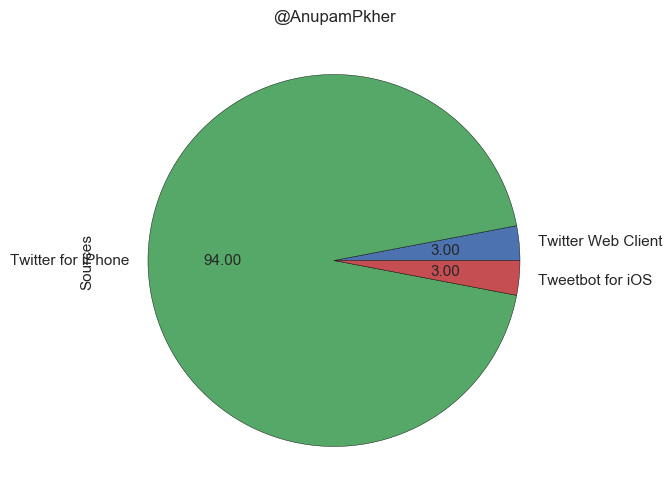

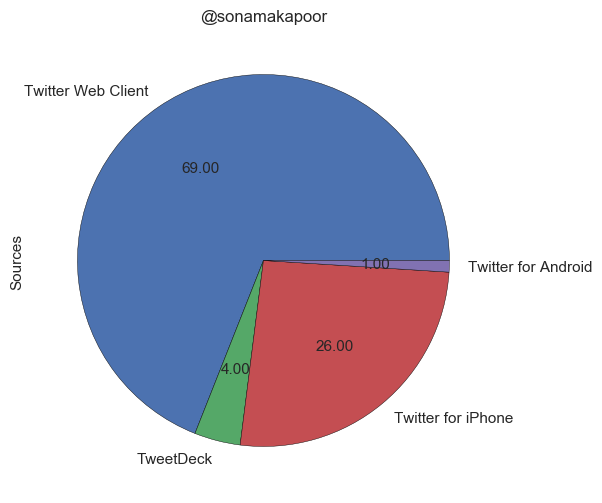

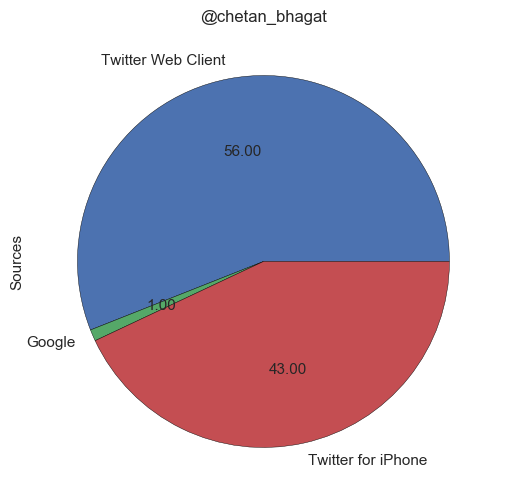

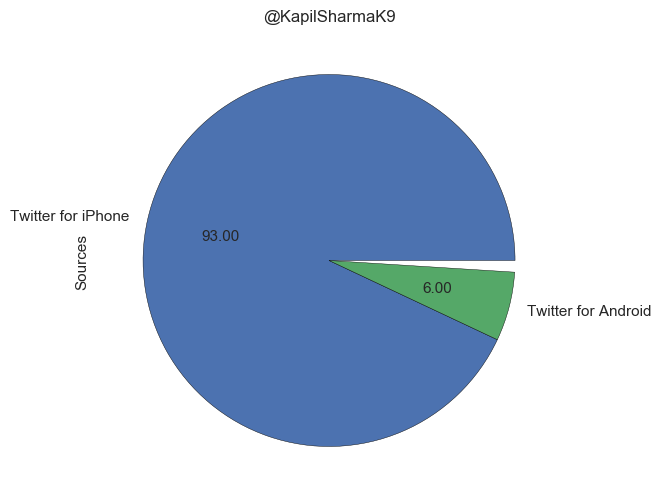

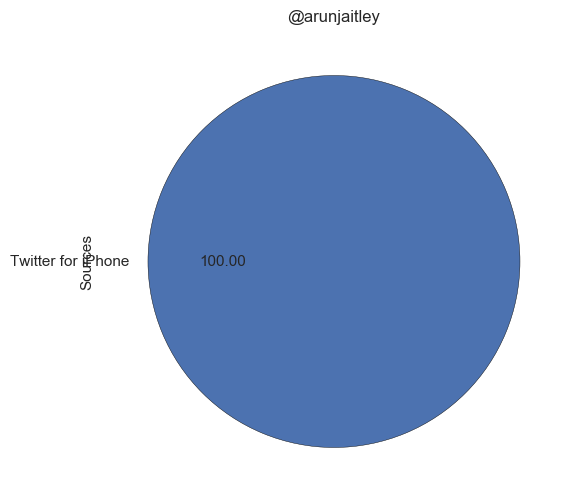

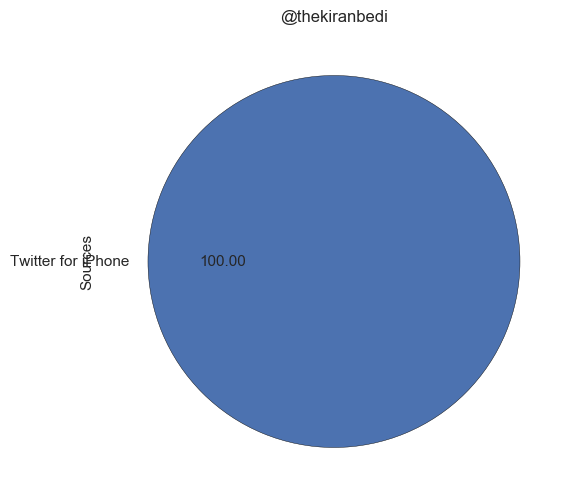

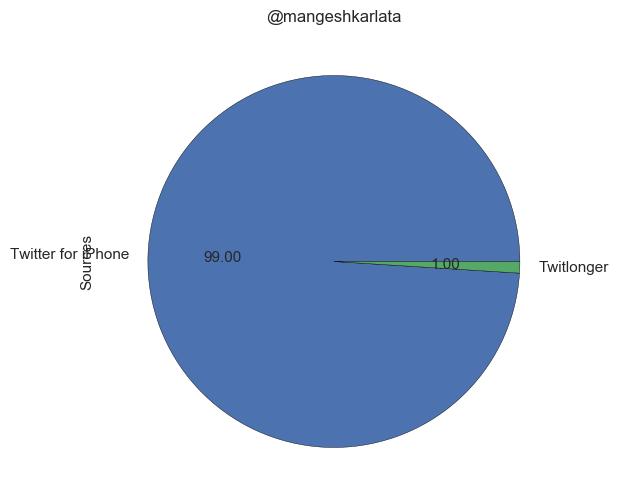

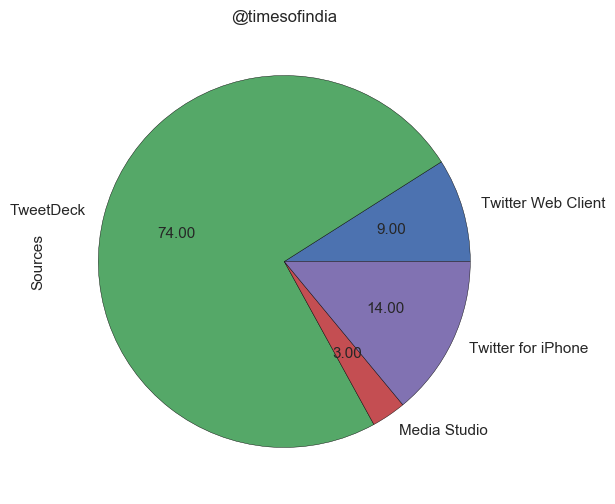

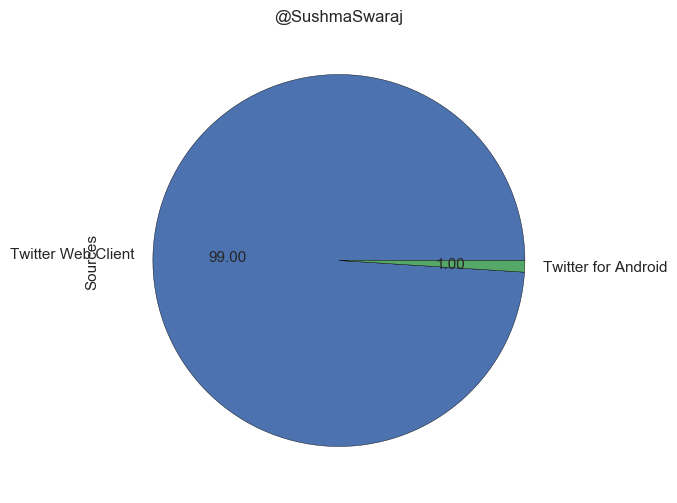

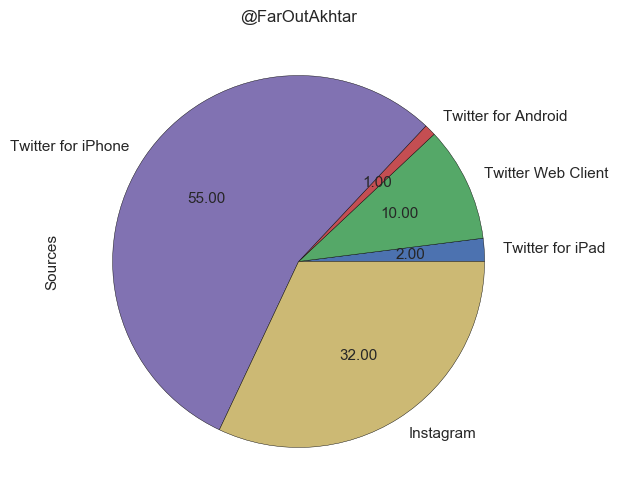

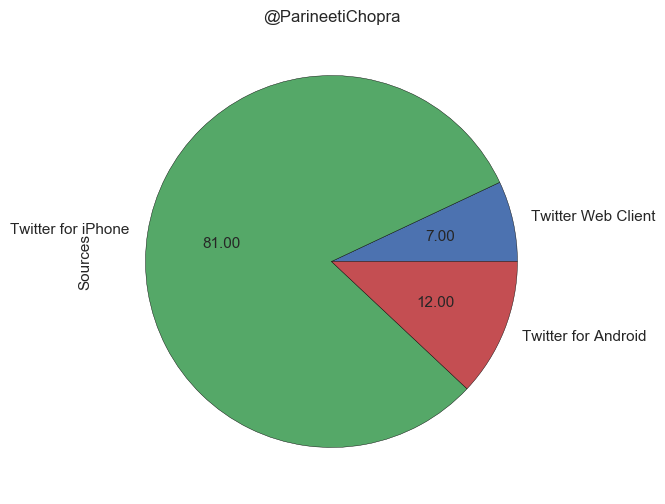

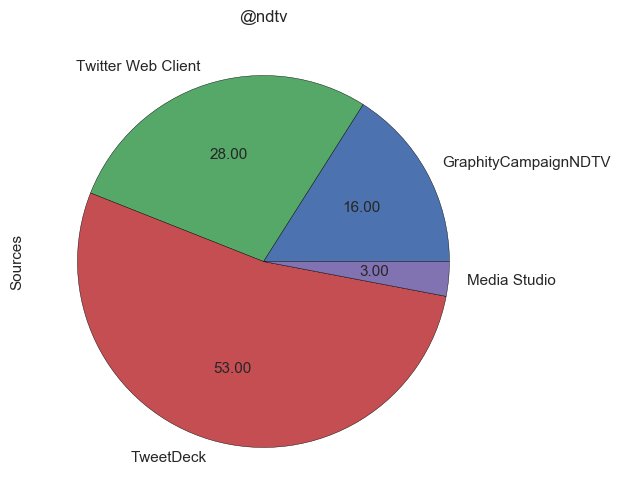

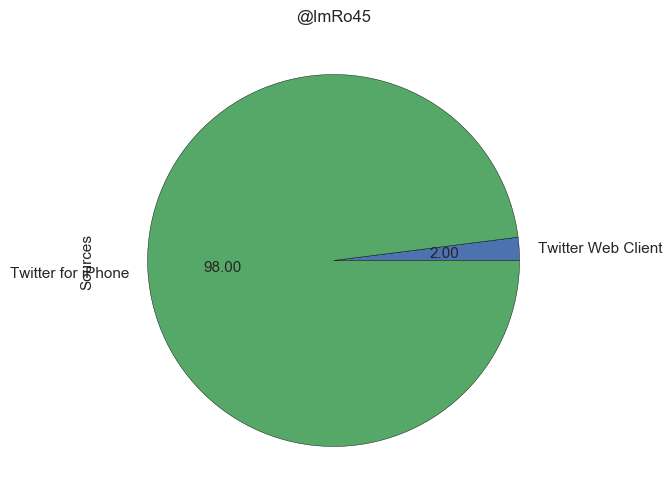

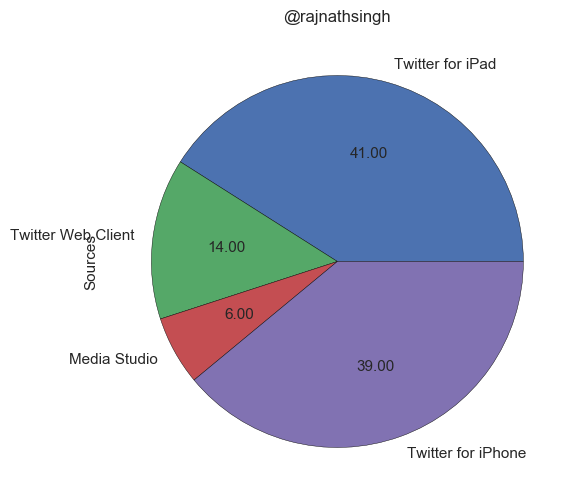

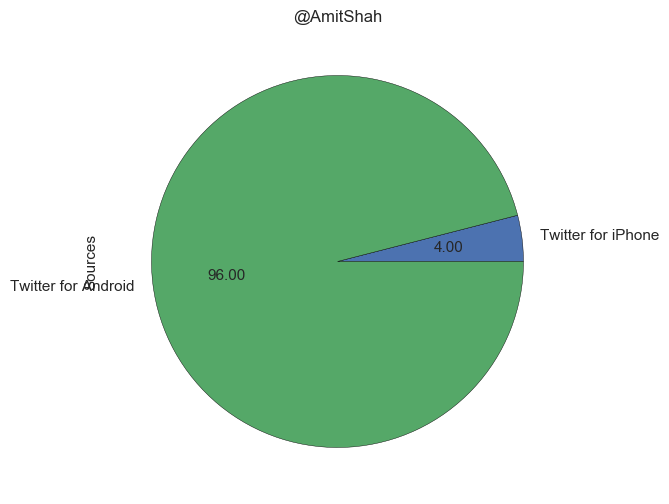

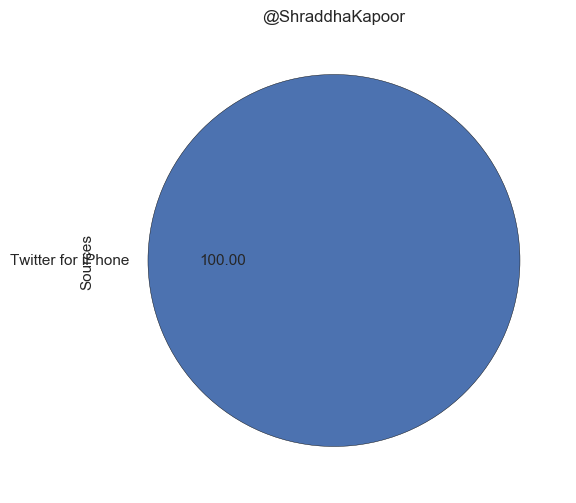

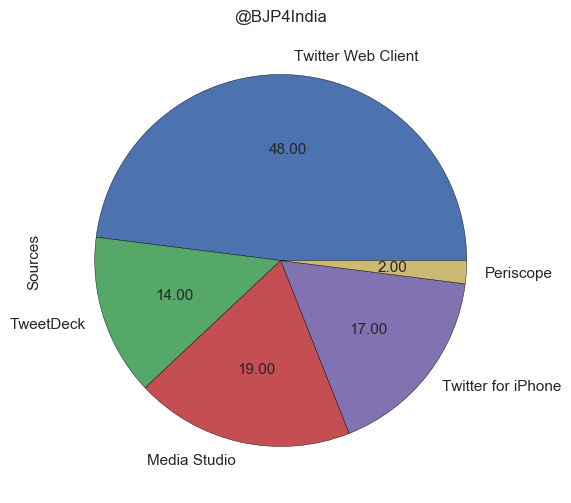

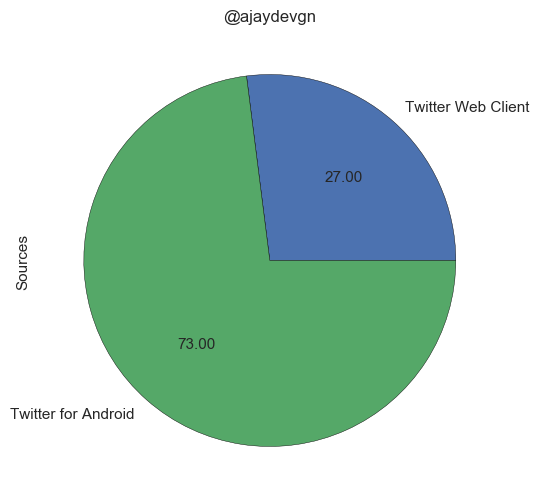

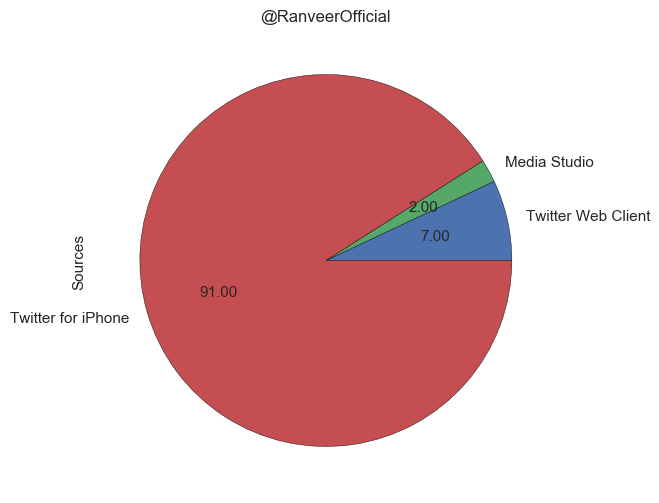

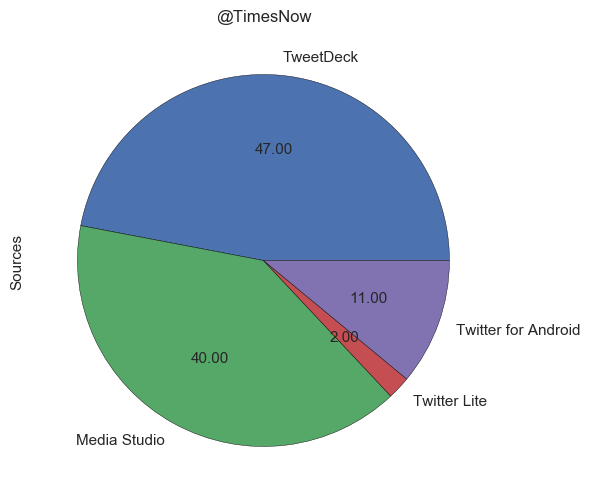

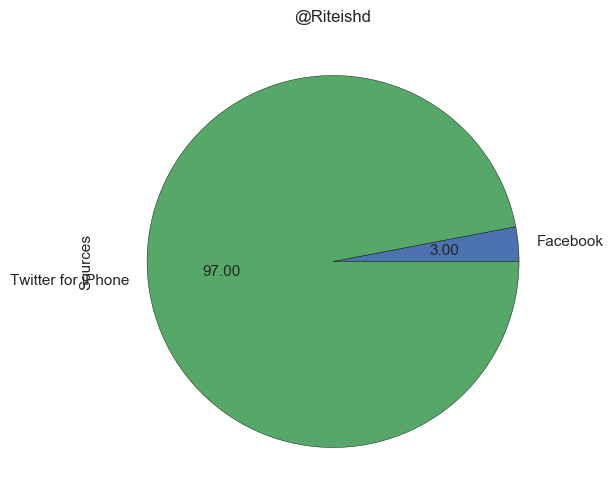

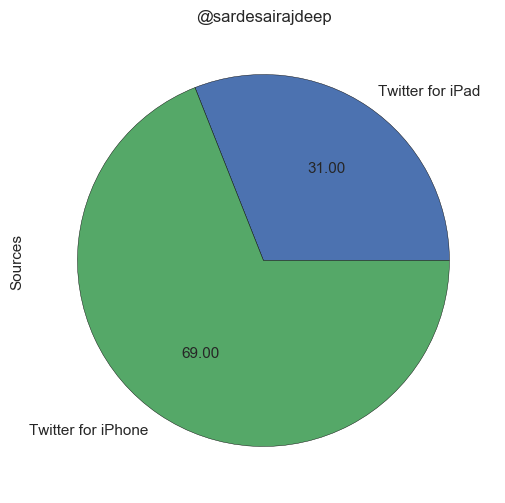

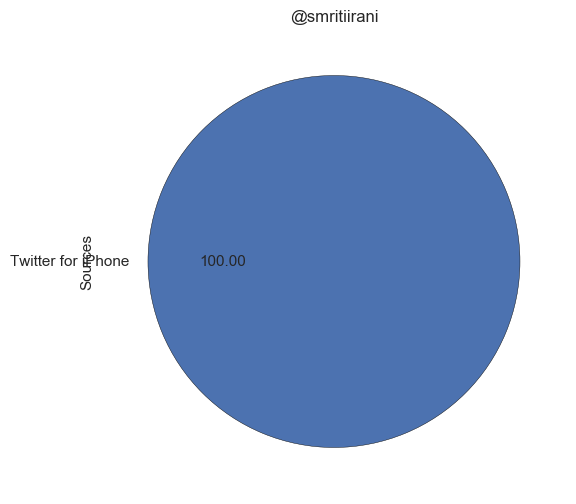

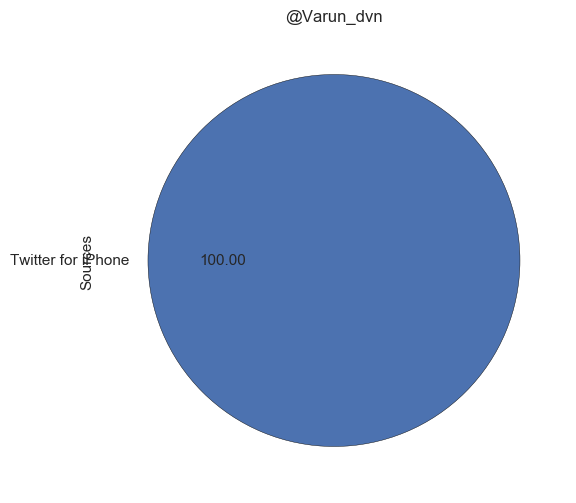

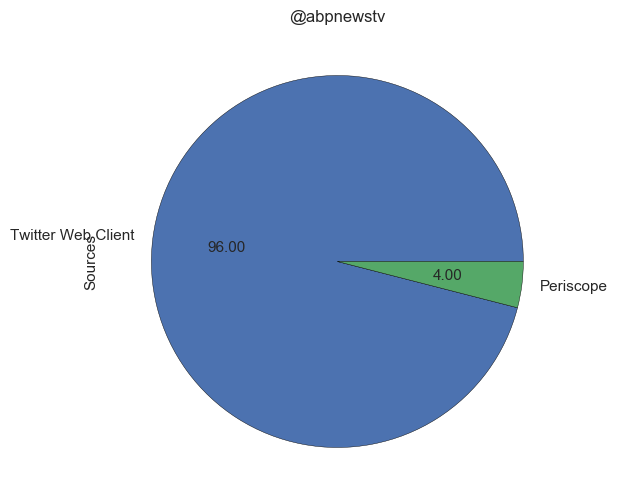

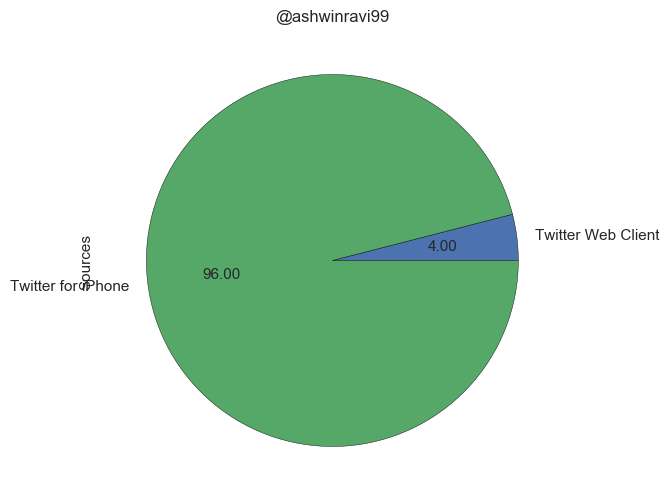

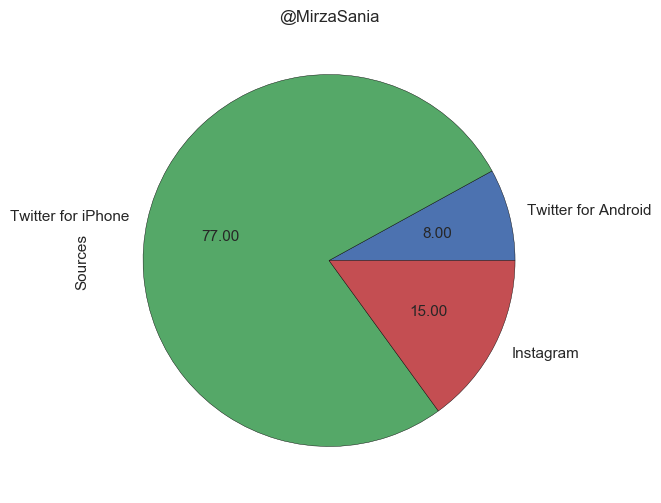

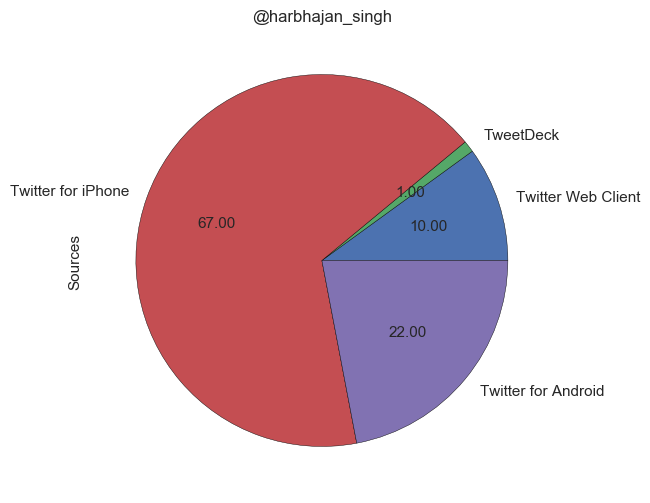

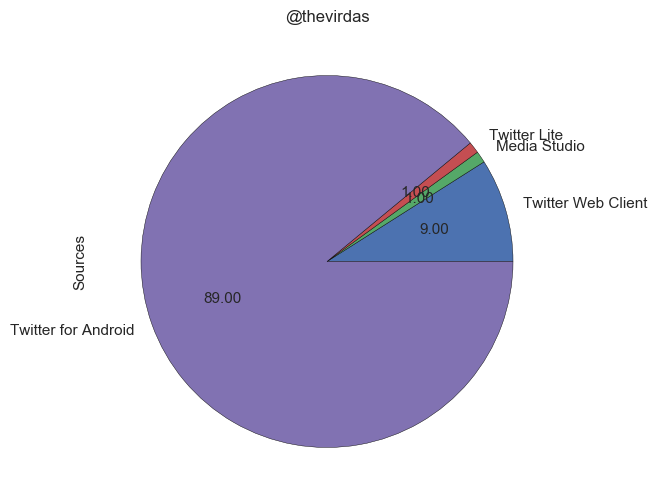

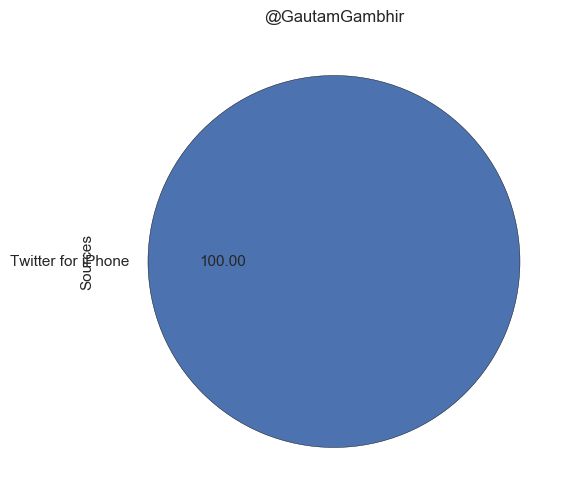

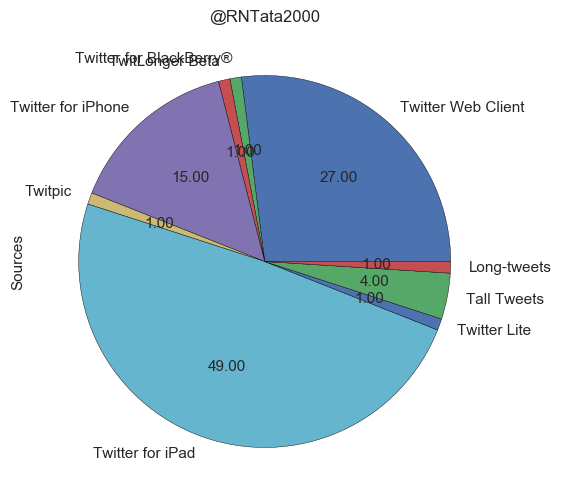

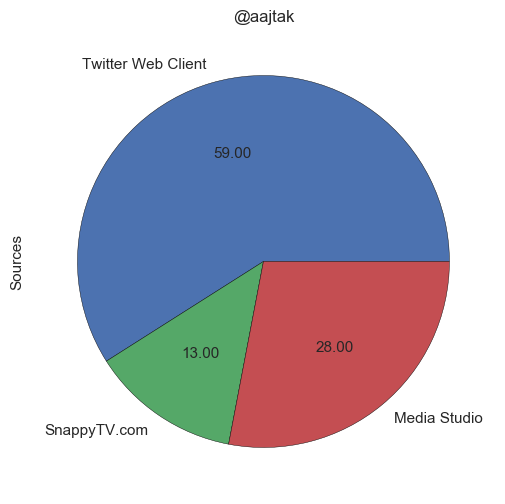

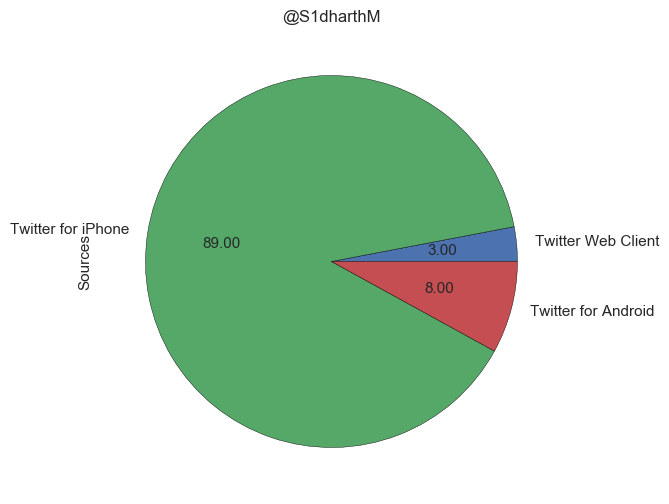

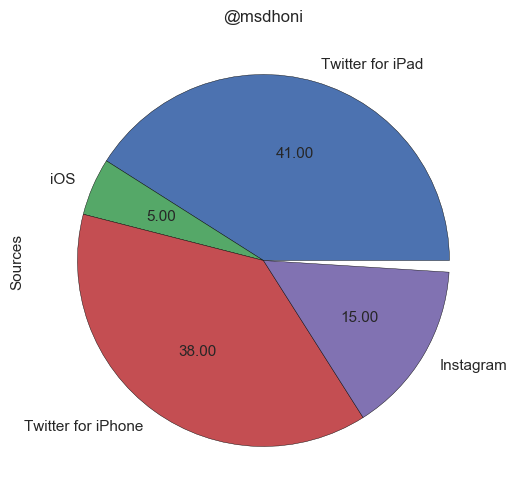

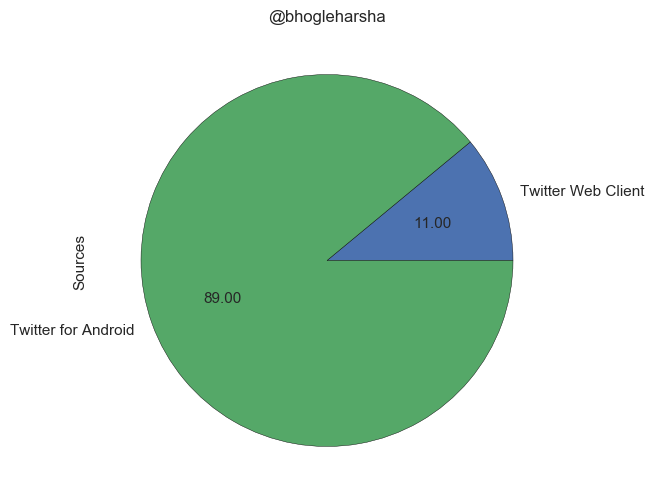

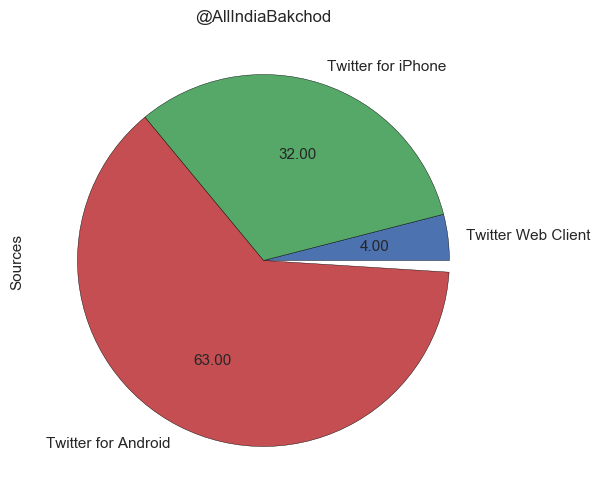

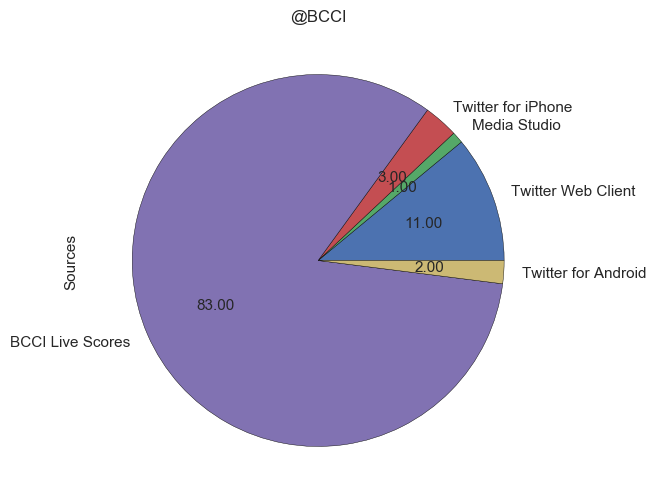

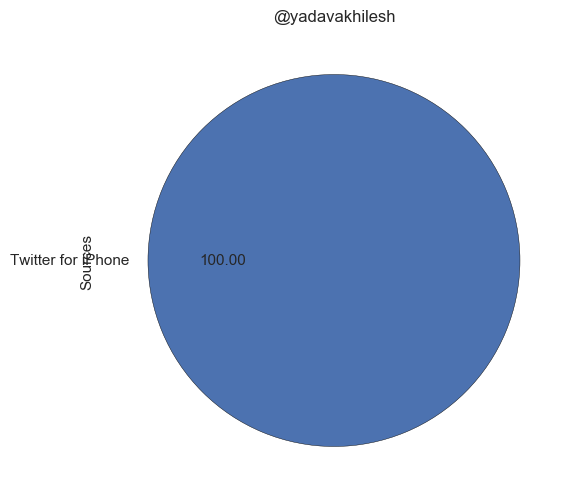

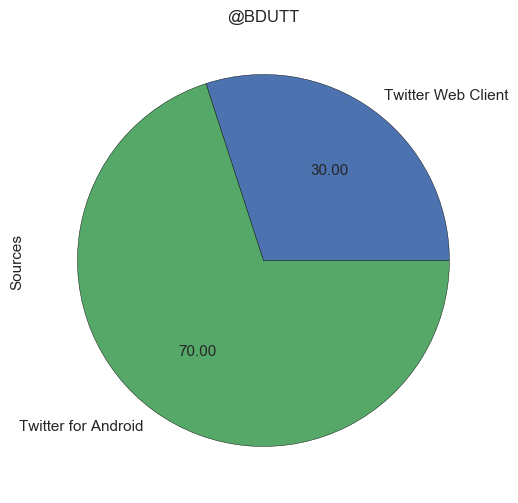

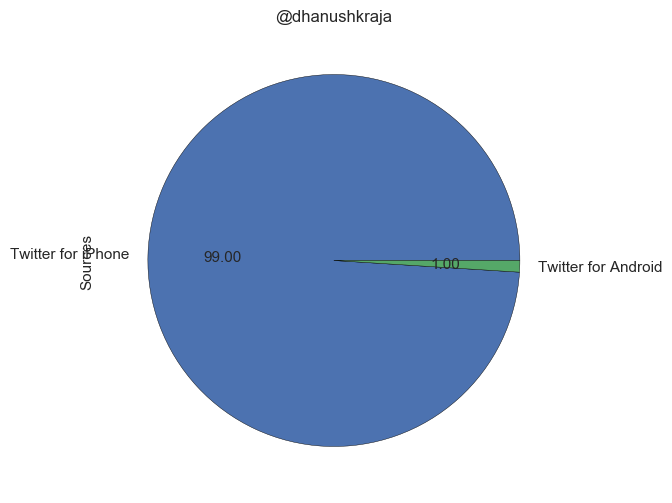

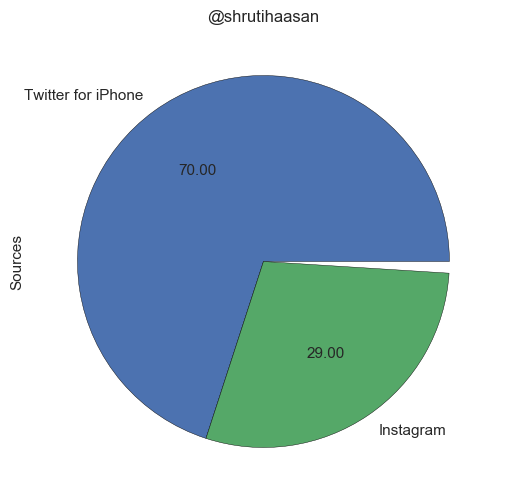

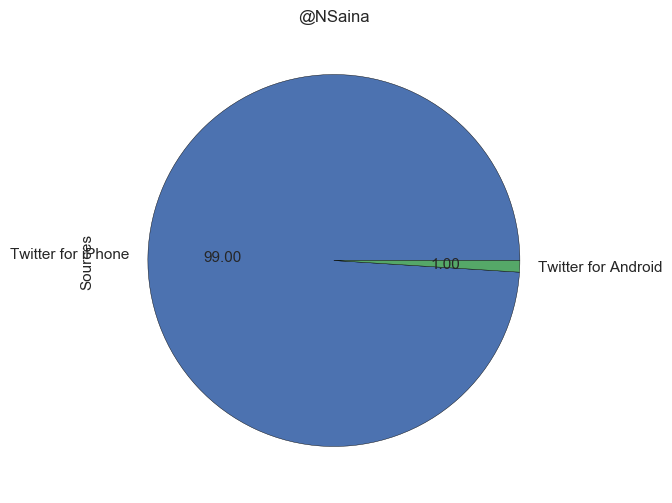

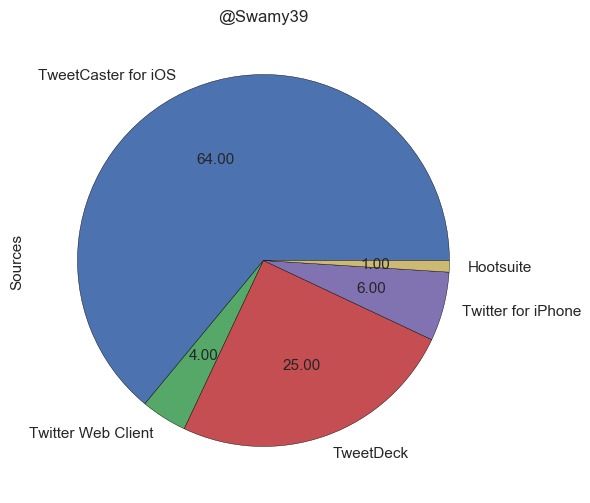

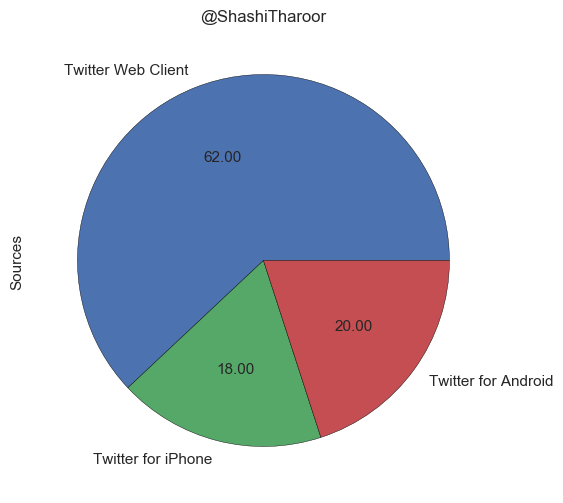

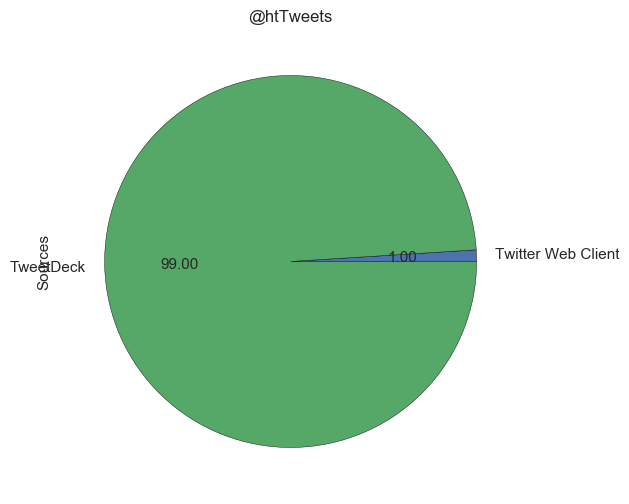

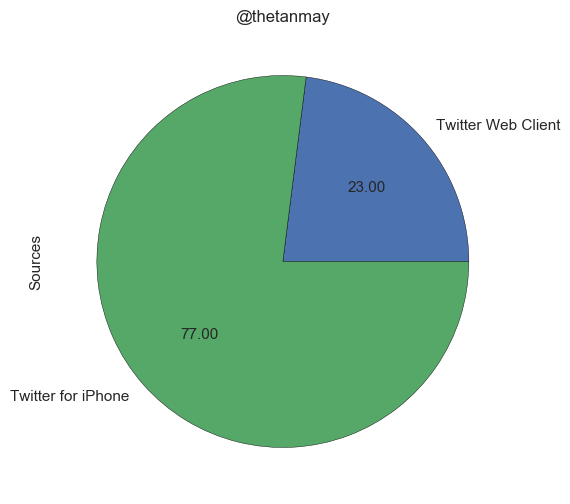

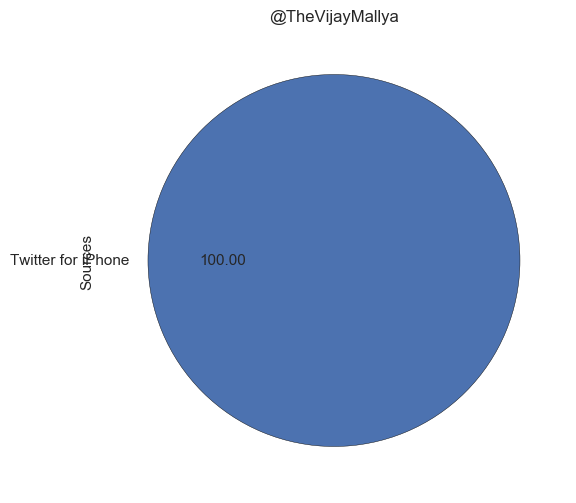

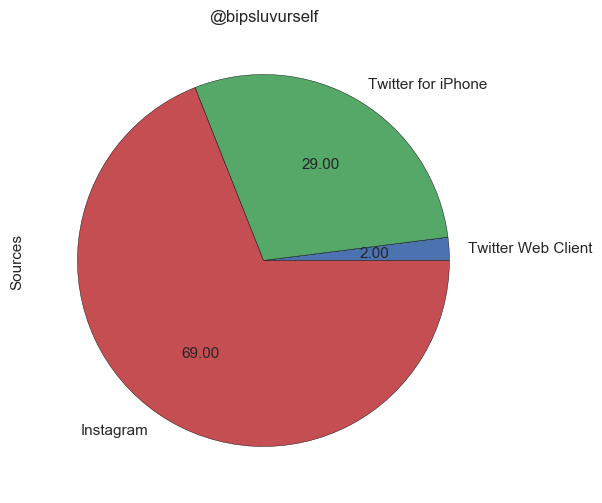

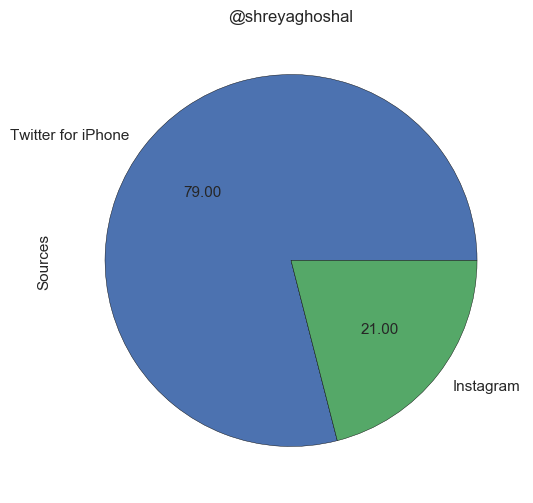

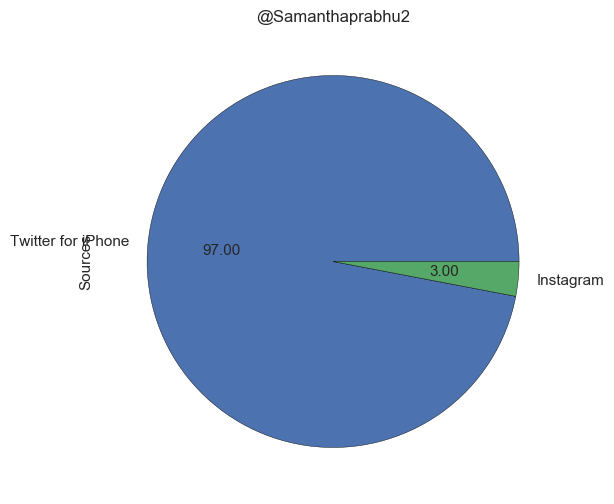

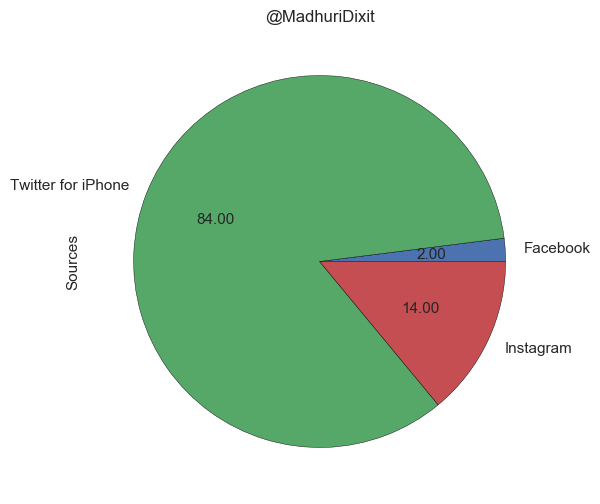

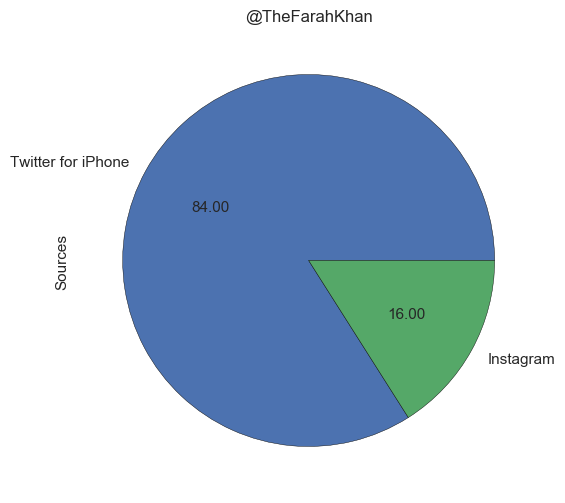

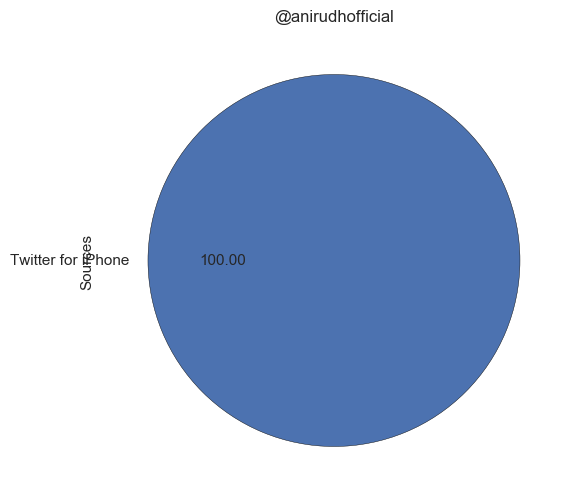

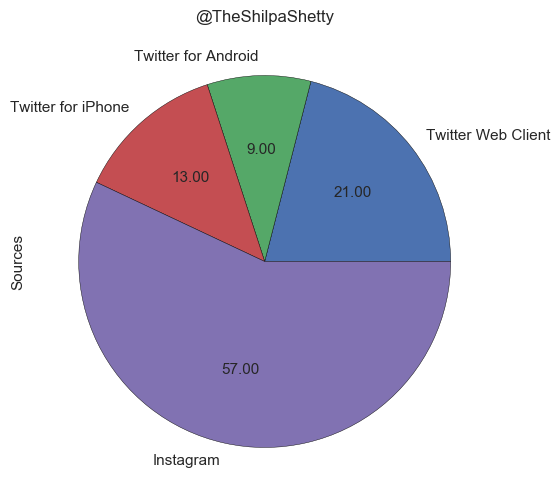

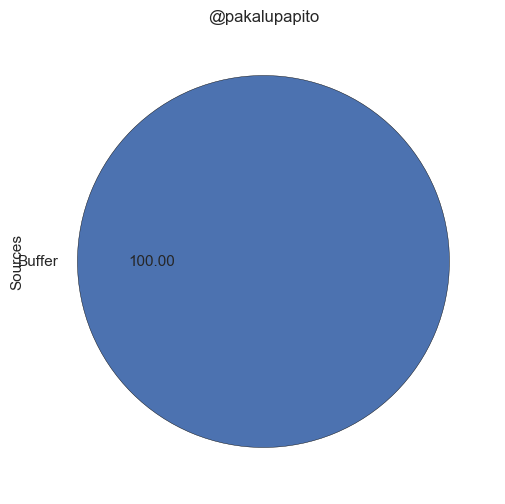

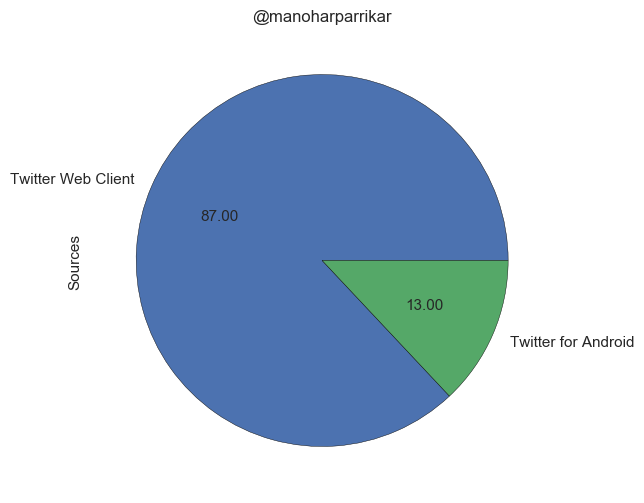

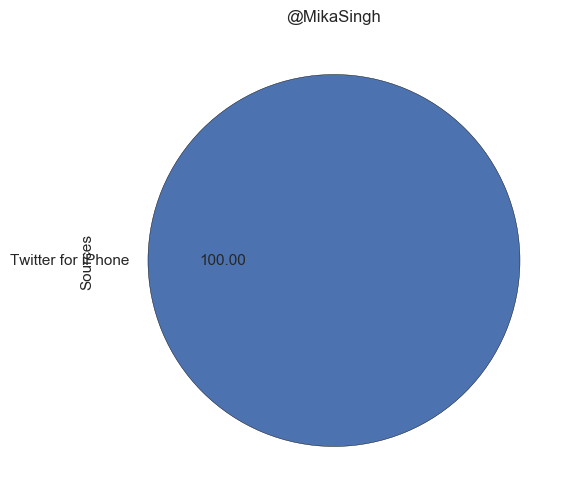

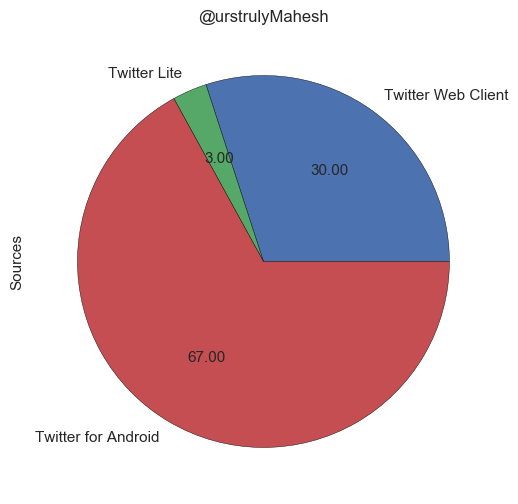

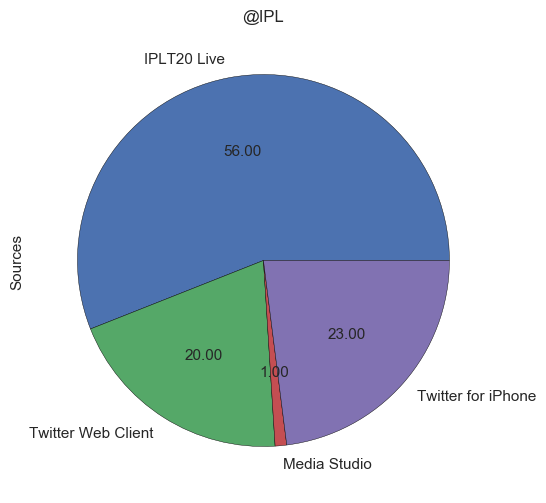

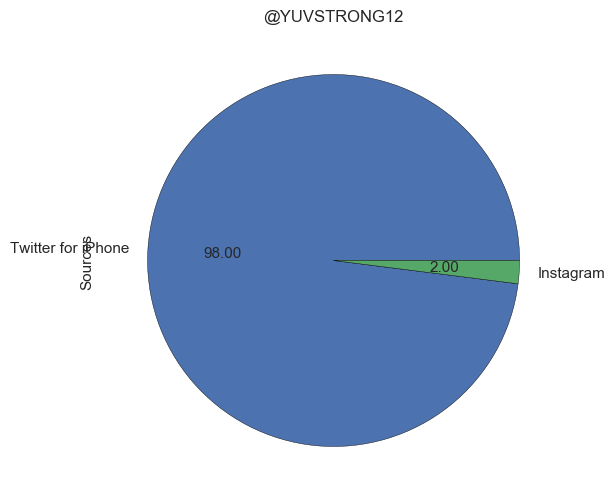

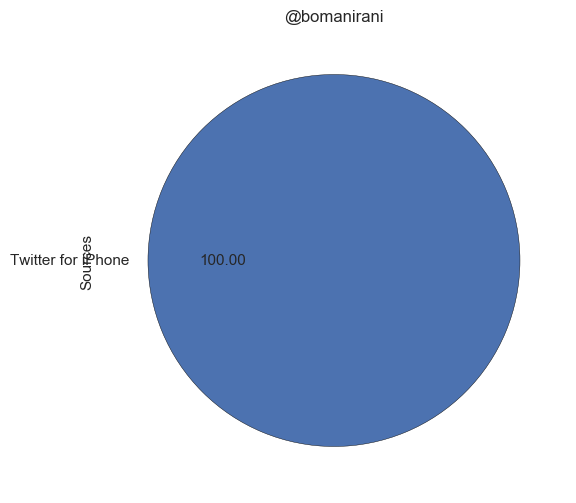

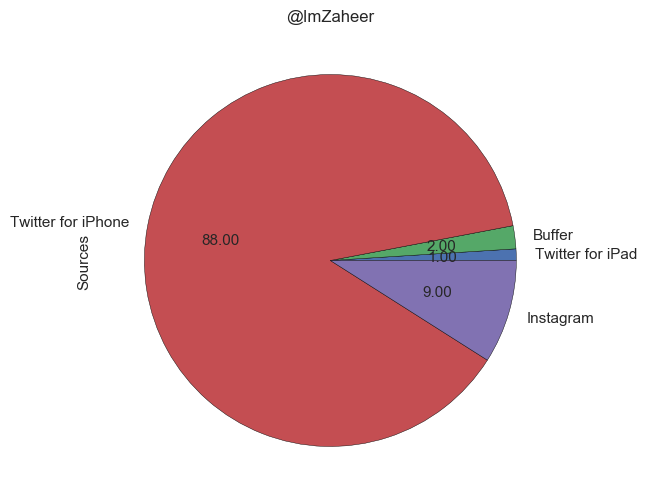

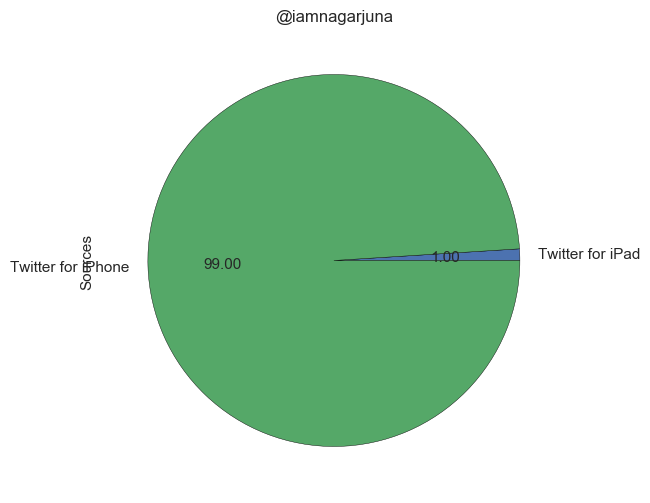

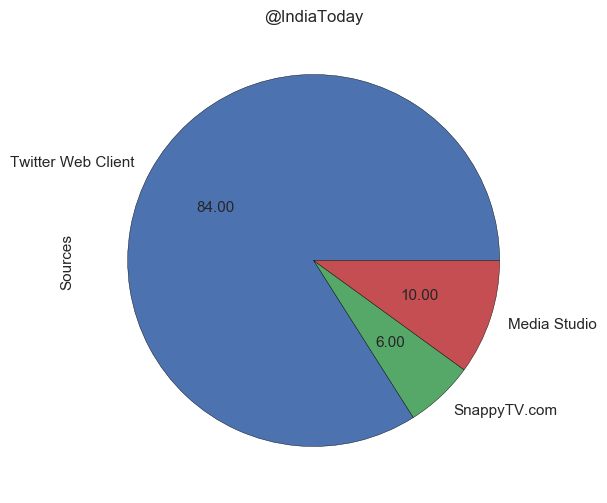

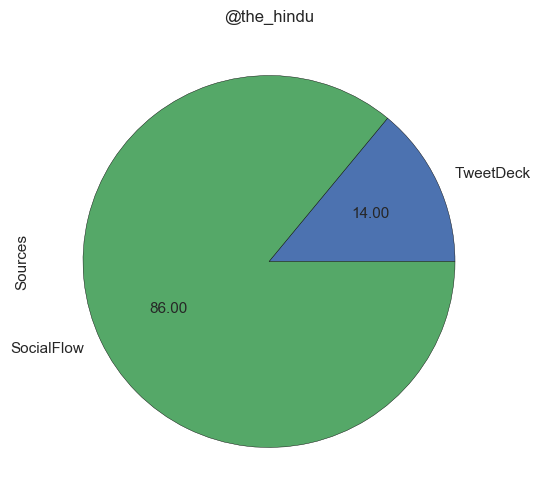

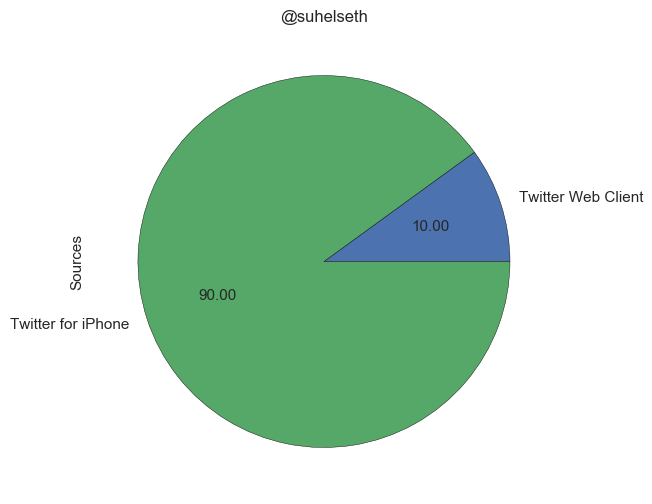

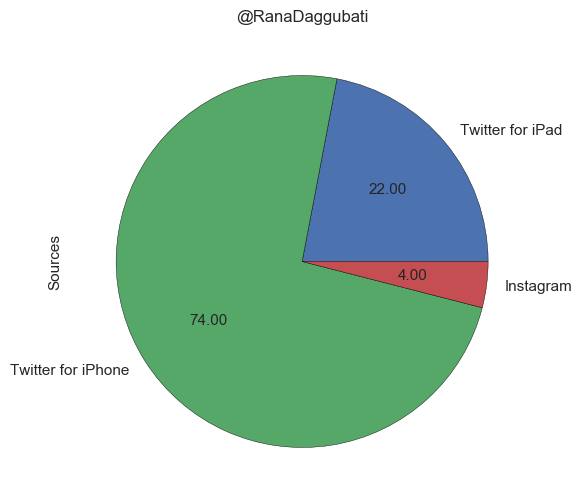

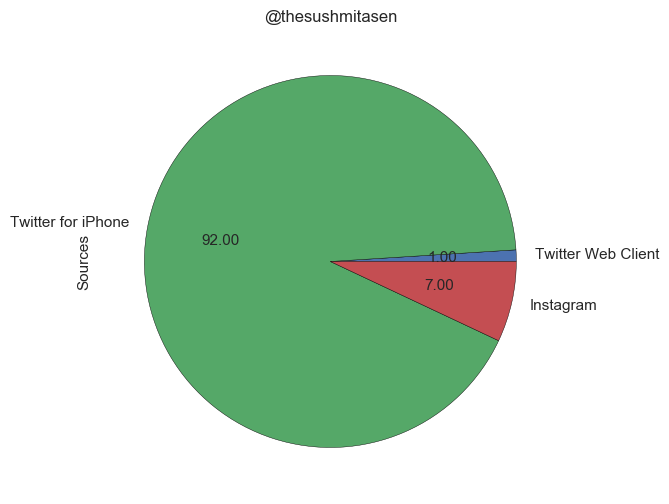

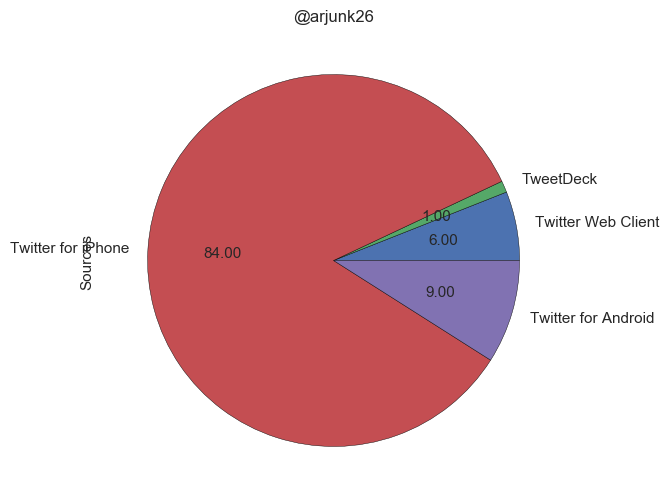

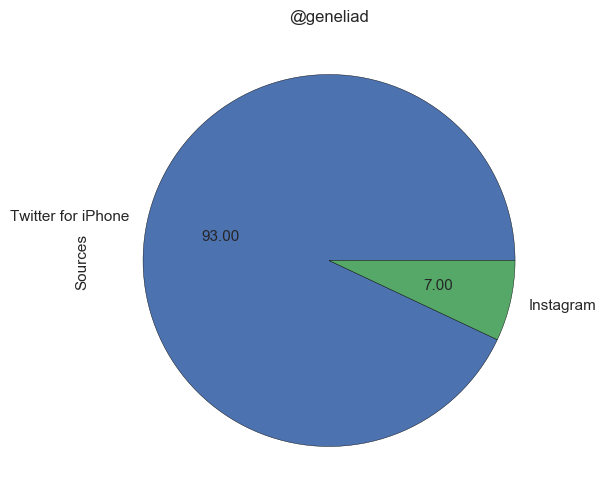

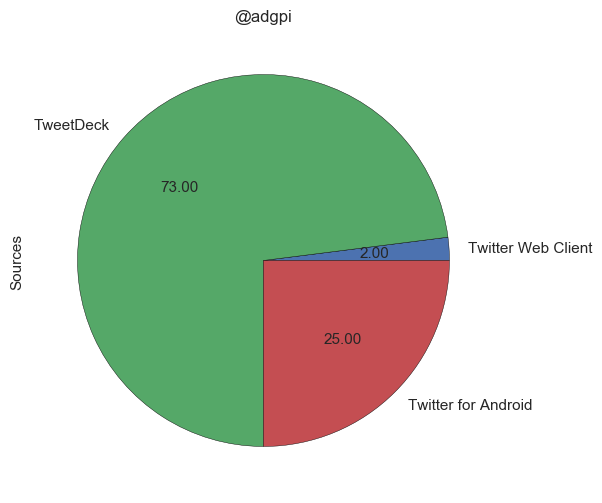

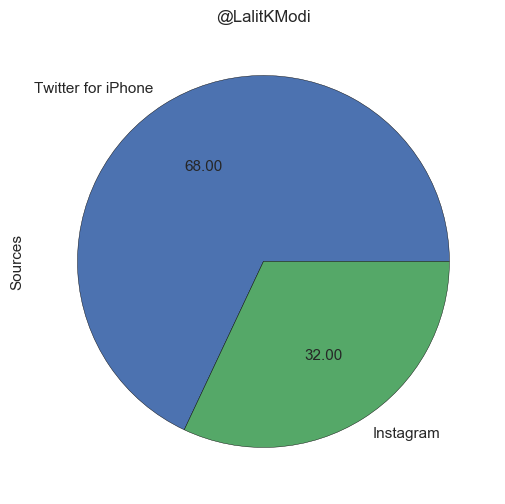

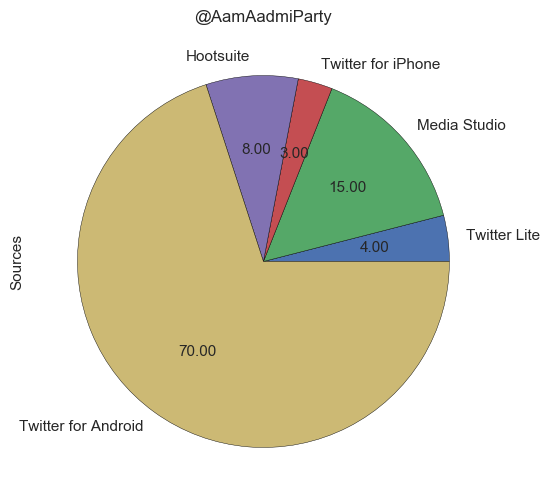

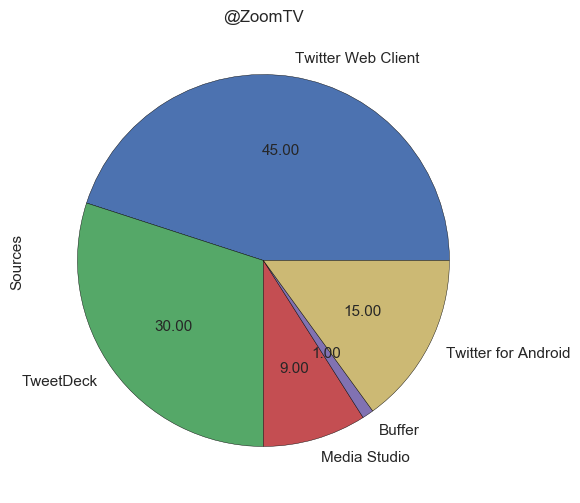

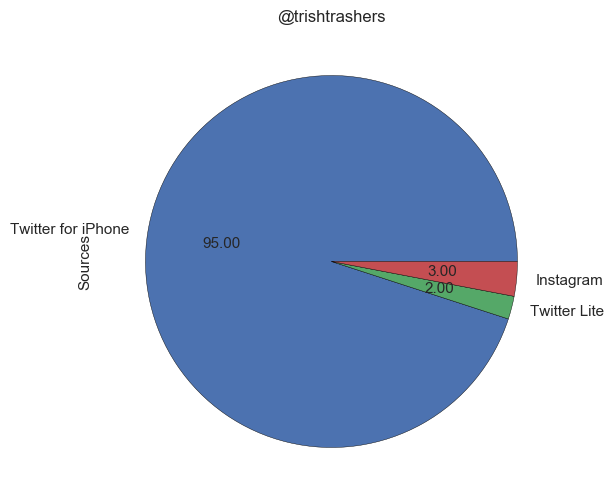

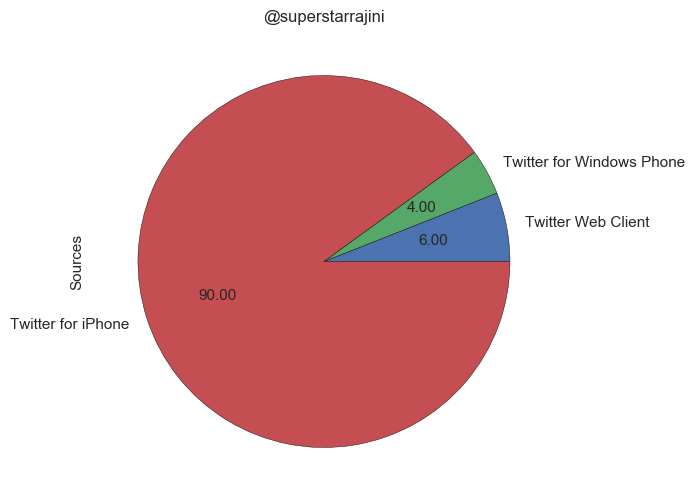

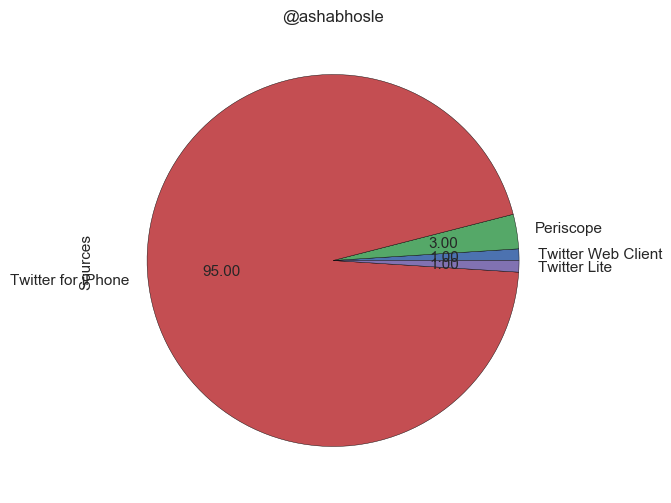

In [399]:
for i in tweeterNames:
    fig, axs = plt.subplots(1,1)
    identifySources(i)

# Topic Modeling


In [3]:
username = '@narendramodi'

twitterName = username + '_tweets.csv'
data = pd.read_csv(twitterName)

In [4]:
data.head()

,text,source
0,b'Do tune in at 11 AM tomorrow. #MannKiBaat ht...,Twitter for iPhone
1,"b'RT @PMOIndia: At 10:15 AM tomorrow, PM @nare...",Twitter Web Client
2,"b""Congratulations @vishy64theking! You've prov...",Twitter for iPhone
3,b'Warm birthday greetings to my valued colleag...,Twitter for iPhone
4,"b'In Shimla, relished coffee at the Indian Cof...",Twitter Web Client


In [9]:
#Cleaning your document: Tokenizing, Stop word removal, stemming
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from gensim import corpora, models
import gensim

In [72]:
texts = []
#Stop words
en_stop = get_stop_words('en')
additional_stop_words = ['b','xe2', 'x80', 'xa6', 'xe0', 'xa4', 'xa5', 'xbe', 'xb0', 'x95', 'x9c', 'x82', 'xb5', 'x87'
                        ,'xaf', 'rt', 'x99', 'xb2', 'xbf', 'x97', 'x81']

for i in additional_stop_words:
    en_stop.append(i)

tokenizer = RegexpTokenizer(r'\w+')
    

In [66]:
def preprocessText(username):
    
    twitterName = username + '_tweets.csv'
    data = pd.read_csv(twitterName)
    
    for i in range(0, len(data)):
    
        raw = data.loc[i, 'text']
        raw = clean_tweet(raw)
        tokens = tokenizer.tokenize(raw.lower())
        
        #Remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        #Stemming
        p_stemmer = PorterStemmer()
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        
        # add tokens to list
        texts.append(stemmed_tokens)
        
    return texts
        

In [73]:
namo = preprocessText('@narendramodi')

In [74]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [75]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [76]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

In [77]:
ldamodel.print_topics(num_topics=10)

[(0,
  '0.019*"ji" + 0.011*"govern" + 0.011*"northeast" + 0.011*"mizoram" + 0.008*"xb8" + 0.008*"xaa" + 0.008*"x8d" + 0.008*"connect" + 0.008*"greet" + 0.008*"atal"'),
 (1,
  '0.022*"n" + 0.015*"share" + 0.015*"scheme" + 0.011*"pradesh" + 0.011*"coffe" + 0.011*"vote" + 0.011*"will" + 0.011*"positiveindia" + 0.008*"meet" + 0.008*"himach"'),
 (2,
  '0.021*"peopl" + 0.018*"bjp" + 0.011*"opportun" + 0.011*"s" + 0.011*"guru" + 0.011*"sri" + 0.011*"state" + 0.007*"meghalaya" + 0.007*"interact" + 0.007*"x99"'),
 (3,
  '0.020*"gujarat" + 0.020*"will" + 0.014*"share" + 0.014*"peopl" + 0.012*"oath" + 0.012*"tomorrow" + 0.012*"ceremoni" + 0.012*"can" + 0.012*"today" + 0.009*"live"'),
 (4,
  '0.016*"will" + 0.016*"delhi" + 0.016*"new" + 0.012*"inaugur" + 0.012*"peopl" + 0.012*"metro" + 0.012*"line" + 0.009*"shri" + 0.009*"year" + 0.009*"s"')]

#### Data Cleaning

In [2]:
twitterName = '@narendramodi' + '_tweets.csv'
data = pd.read_csv(twitterName)

In [5]:
data["text"].head()

0    b'Do tune in at 11 AM tomorrow. #MannKiBaat ht...
1    b'RT @PMOIndia: At 10:15 AM tomorrow, PM @nare...
2    b"Congratulations @vishy64theking! You've prov...
3    b'Warm birthday greetings to my valued colleag...
4    b'In Shimla, relished coffee at the Indian Cof...
Name: text, dtype: object